# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [5]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

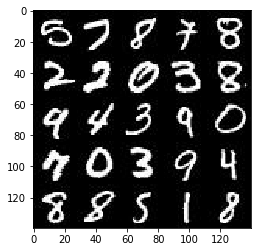

In [6]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

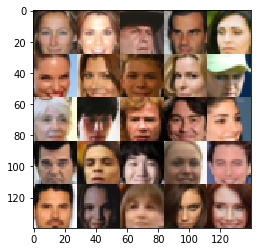

In [7]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
celeba_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(celeba_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [9]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input_images = tf.placeholder(
        tf.float32, 
        shape = [None, image_height, image_width, image_channels], 
        name = 'real_input_images'
    )
    
    z_data = tf.placeholder(
        tf.float32,
        shape = [None, z_dim],
        name = 'z_data'
    )
    
    learning_rate = tf.placeholder(
        tf.float32,
        shape = [],
        name = 'learning_rate'
    )
    
    return real_input_images, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [18]:
def discriminator(images, reuse=False, alpha=0.12):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    # Note this code block largely reproduced from 
    # https://github.com/udacity/deep-learning/tree/master/dcgan-svhn
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        # h1 = tf.layers.dense(flat, 4096, activation = None)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        # print("images input shape", images.shape)
        # print("x1 shape", x1.shape)
        # print("x2 shape", x2.shape)
        # print("x3 shape", x3.shape)
        # print("flat shape", flat.shape)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [19]:
def generator(input_z, out_channel_dim, is_train=True, alpha = 0.12):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    # Note this code block largely reproduced from 
    # https://github.com/udacity/deep-learning/tree/master/dcgan-svhn 
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(input_z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        #x2 = tf.reshape(x1, (-1, 7, 7, 128))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x128 now
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x64 now
        
        #x4 = tf.layers.conv2d_transpose(x3, 32, 5, strides=2, padding='same')
        #x4 = tf.layers.batch_normalization(x4, training=is_train)
        #x4 = tf.maximum(alpha * x4, x4)
        # 28x28x64 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        # 28x28x out_channel_dim now
        
        out = tf.tanh(logits)
        
        #print("input_z shape",input_z.shape)
        #print("x1 shape", x1.shape)
        #print("x2 shape", x2.shape)
        #print("x3 shape", x3.shape)
        #####3#print("x4 shape", x4.shape)
        #print("logits shape", logits.shape)
        
    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [33]:
def model_loss(input_real, input_z, out_channel_dim, alpha = 0.12, smooth = 0.9):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    # Note this code block largely reproduced from 
    # https://github.com/udacity/deep-learning/tree/master/dcgan-svhn
    g_image = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_image, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*smooth))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)*(1-smooth)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)*smooth))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [22]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Note this code block reproduced in entirety from 
    # https://github.com/udacity/deep-learning/tree/master/dcgan-svhn

    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    d_updates = [opt for opt in update_ops if opt.name.startswith('discriminator')]
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]

    with tf.control_dependencies(d_updates):
        d_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)

    with tf.control_dependencies(g_updates):
        g_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
            
    return d_opt, g_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [23]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [24]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    # print("input_real shape",input_real.shape)
    # print("input_z shape", input_z.shape)
    # print("output_channel_dim", data_shape[3])
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3], alpha=0.12)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
               
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})

                # print losses every 10 steps
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                # show generator output every 100 steps
                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
   

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.7736... Generator Loss: 5.5166
Epoch 1/2... Discriminator Loss: 3.8502... Generator Loss: 0.4209
Epoch 1/2... Discriminator Loss: 1.7323... Generator Loss: 0.6370
Epoch 1/2... Discriminator Loss: 1.4080... Generator Loss: 0.8115
Epoch 1/2... Discriminator Loss: 1.5303... Generator Loss: 1.4131
Epoch 1/2... Discriminator Loss: 1.9595... Generator Loss: 0.4346
Epoch 1/2... Discriminator Loss: 1.8154... Generator Loss: 0.4123
Epoch 1/2... Discriminator Loss: 1.6496... Generator Loss: 0.5135
Epoch 1/2... Discriminator Loss: 1.2786... Generator Loss: 1.0215
Epoch 1/2... Discriminator Loss: 1.5627... Generator Loss: 0.8595


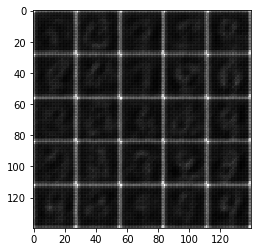

Epoch 1/2... Discriminator Loss: 1.3856... Generator Loss: 0.7965
Epoch 1/2... Discriminator Loss: 1.3592... Generator Loss: 0.8359
Epoch 1/2... Discriminator Loss: 1.3784... Generator Loss: 0.8248
Epoch 1/2... Discriminator Loss: 1.2629... Generator Loss: 1.0971
Epoch 1/2... Discriminator Loss: 1.5863... Generator Loss: 0.4711
Epoch 1/2... Discriminator Loss: 1.3622... Generator Loss: 0.6689
Epoch 1/2... Discriminator Loss: 1.4183... Generator Loss: 0.5504
Epoch 1/2... Discriminator Loss: 1.8811... Generator Loss: 0.3932
Epoch 1/2... Discriminator Loss: 1.3772... Generator Loss: 0.7135
Epoch 1/2... Discriminator Loss: 1.2046... Generator Loss: 0.8013


Epoch 1/2... Discriminator Loss: 1.1885... Generator Loss: 0.7525
Epoch 1/2... Discriminator Loss: 1.6074... Generator Loss: 0.5043
Epoch 1/2... Discriminator Loss: 1.1714... Generator Loss: 0.8681
Epoch 1/2... Discriminator Loss: 1.3719... Generator Loss: 0.6602
Epoch 1/2... Discriminator Loss: 1.3901... Generator Loss: 0.6508
Epoch 1/2... Discriminator Loss: 1.2537... Generator Loss: 1.1577
Epoch 1/2... Discriminator Loss: 1.1645... Generator Loss: 0.7892
Epoch 1/2... Discriminator Loss: 1.1356... Generator Loss: 1.4824
Epoch 1/2... Discriminator Loss: 1.3060... Generator Loss: 0.6264
Epoch 1/2... Discriminator Loss: 1.4677... Generator Loss: 0.5742


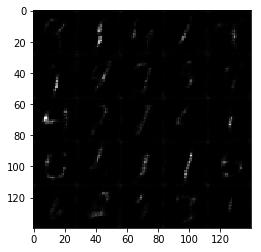

Epoch 1/2... Discriminator Loss: 1.2832... Generator Loss: 0.6434
Epoch 1/2... Discriminator Loss: 1.1768... Generator Loss: 0.9948
Epoch 1/2... Discriminator Loss: 1.4146... Generator Loss: 0.8942
Epoch 1/2... Discriminator Loss: 1.5497... Generator Loss: 1.8852
Epoch 1/2... Discriminator Loss: 1.2509... Generator Loss: 1.0242
Epoch 1/2... Discriminator Loss: 1.8145... Generator Loss: 0.4185
Epoch 1/2... Discriminator Loss: 1.5416... Generator Loss: 0.5821
Epoch 1/2... Discriminator Loss: 1.2510... Generator Loss: 0.9165
Epoch 1/2... Discriminator Loss: 1.3424... Generator Loss: 0.6359
Epoch 1/2... Discriminator Loss: 1.2371... Generator Loss: 0.8901


Epoch 1/2... Discriminator Loss: 1.2849... Generator Loss: 0.7022
Epoch 1/2... Discriminator Loss: 1.3730... Generator Loss: 0.5971
Epoch 1/2... Discriminator Loss: 1.1300... Generator Loss: 0.7775
Epoch 1/2... Discriminator Loss: 1.1403... Generator Loss: 1.1634
Epoch 1/2... Discriminator Loss: 1.4074... Generator Loss: 1.5073
Epoch 1/2... Discriminator Loss: 1.1721... Generator Loss: 0.8437
Epoch 1/2... Discriminator Loss: 1.3252... Generator Loss: 0.7016
Epoch 1/2... Discriminator Loss: 1.5810... Generator Loss: 0.4795
Epoch 1/2... Discriminator Loss: 1.2105... Generator Loss: 0.7133
Epoch 1/2... Discriminator Loss: 1.1471... Generator Loss: 0.7857


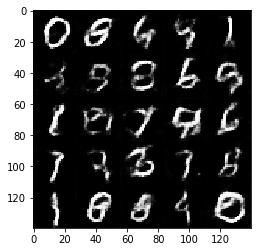

Epoch 1/2... Discriminator Loss: 1.3075... Generator Loss: 0.6652
Epoch 1/2... Discriminator Loss: 1.3112... Generator Loss: 0.7801
Epoch 1/2... Discriminator Loss: 1.5938... Generator Loss: 0.5102
Epoch 1/2... Discriminator Loss: 1.3285... Generator Loss: 0.5957
Epoch 1/2... Discriminator Loss: 1.1779... Generator Loss: 0.8472
Epoch 1/2... Discriminator Loss: 0.9909... Generator Loss: 0.9130
Epoch 1/2... Discriminator Loss: 1.6714... Generator Loss: 0.4744
Epoch 1/2... Discriminator Loss: 1.4218... Generator Loss: 0.5458
Epoch 1/2... Discriminator Loss: 1.0562... Generator Loss: 0.9231
Epoch 1/2... Discriminator Loss: 1.3661... Generator Loss: 0.6297


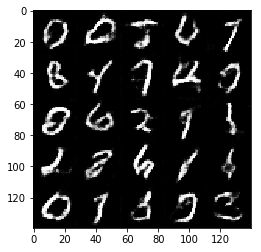

Epoch 1/2... Discriminator Loss: 1.1134... Generator Loss: 0.7472
Epoch 1/2... Discriminator Loss: 1.0457... Generator Loss: 1.0928
Epoch 1/2... Discriminator Loss: 1.1805... Generator Loss: 0.7517
Epoch 1/2... Discriminator Loss: 1.1244... Generator Loss: 1.5495
Epoch 1/2... Discriminator Loss: 1.6151... Generator Loss: 0.4594
Epoch 1/2... Discriminator Loss: 1.2127... Generator Loss: 0.6881
Epoch 1/2... Discriminator Loss: 1.8317... Generator Loss: 0.4222
Epoch 1/2... Discriminator Loss: 1.2098... Generator Loss: 0.7134
Epoch 1/2... Discriminator Loss: 1.1723... Generator Loss: 1.2962
Epoch 1/2... Discriminator Loss: 0.9064... Generator Loss: 1.0829


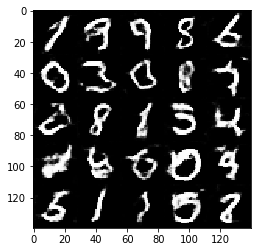

Epoch 1/2... Discriminator Loss: 1.3398... Generator Loss: 0.5857
Epoch 1/2... Discriminator Loss: 1.6114... Generator Loss: 0.5113
Epoch 1/2... Discriminator Loss: 1.0042... Generator Loss: 1.1358
Epoch 1/2... Discriminator Loss: 0.9956... Generator Loss: 0.9885
Epoch 1/2... Discriminator Loss: 1.3037... Generator Loss: 0.6102
Epoch 1/2... Discriminator Loss: 1.2884... Generator Loss: 1.5265
Epoch 1/2... Discriminator Loss: 1.0583... Generator Loss: 0.8276
Epoch 1/2... Discriminator Loss: 1.0957... Generator Loss: 0.8239
Epoch 1/2... Discriminator Loss: 1.1996... Generator Loss: 0.8515
Epoch 1/2... Discriminator Loss: 1.2135... Generator Loss: 0.8869


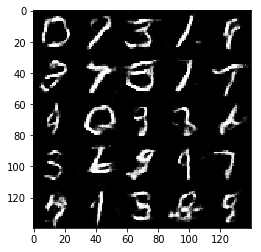

Epoch 1/2... Discriminator Loss: 1.2576... Generator Loss: 0.6069
Epoch 1/2... Discriminator Loss: 1.3290... Generator Loss: 0.5751
Epoch 1/2... Discriminator Loss: 1.3246... Generator Loss: 0.6085
Epoch 1/2... Discriminator Loss: 1.0834... Generator Loss: 0.8384
Epoch 1/2... Discriminator Loss: 0.8327... Generator Loss: 1.4323
Epoch 1/2... Discriminator Loss: 1.5155... Generator Loss: 2.0476
Epoch 1/2... Discriminator Loss: 1.1978... Generator Loss: 0.9472
Epoch 1/2... Discriminator Loss: 1.2554... Generator Loss: 0.6828
Epoch 1/2... Discriminator Loss: 1.1470... Generator Loss: 0.7609
Epoch 1/2... Discriminator Loss: 1.9924... Generator Loss: 0.3954


Epoch 1/2... Discriminator Loss: 1.0966... Generator Loss: 0.8037
Epoch 1/2... Discriminator Loss: 0.9060... Generator Loss: 1.4160
Epoch 1/2... Discriminator Loss: 1.4441... Generator Loss: 0.5859
Epoch 1/2... Discriminator Loss: 1.8483... Generator Loss: 0.4257
Epoch 1/2... Discriminator Loss: 1.0718... Generator Loss: 0.8728
Epoch 1/2... Discriminator Loss: 1.7835... Generator Loss: 0.4524
Epoch 1/2... Discriminator Loss: 1.3092... Generator Loss: 0.6610
Epoch 1/2... Discriminator Loss: 1.0926... Generator Loss: 1.3258
Epoch 1/2... Discriminator Loss: 1.2795... Generator Loss: 0.6438
Epoch 1/2... Discriminator Loss: 1.1173... Generator Loss: 0.9958


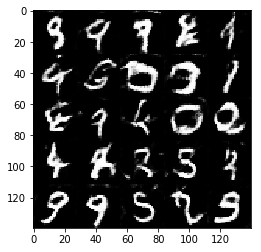

Epoch 1/2... Discriminator Loss: 1.3547... Generator Loss: 0.8352
Epoch 1/2... Discriminator Loss: 1.0439... Generator Loss: 1.3905
Epoch 1/2... Discriminator Loss: 1.3424... Generator Loss: 0.5936
Epoch 1/2... Discriminator Loss: 1.2542... Generator Loss: 0.9751
Epoch 1/2... Discriminator Loss: 1.5204... Generator Loss: 0.5127
Epoch 1/2... Discriminator Loss: 1.6953... Generator Loss: 0.4617
Epoch 1/2... Discriminator Loss: 1.5915... Generator Loss: 0.4875
Epoch 1/2... Discriminator Loss: 0.9735... Generator Loss: 1.0674
Epoch 1/2... Discriminator Loss: 1.9132... Generator Loss: 0.4120
Epoch 1/2... Discriminator Loss: 1.6036... Generator Loss: 0.5082


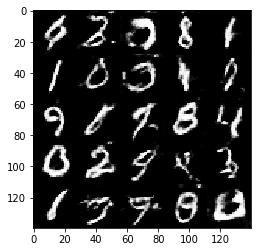

Epoch 1/2... Discriminator Loss: 1.0525... Generator Loss: 0.7950
Epoch 1/2... Discriminator Loss: 1.0917... Generator Loss: 1.0229
Epoch 1/2... Discriminator Loss: 1.0075... Generator Loss: 0.8988
Epoch 1/2... Discriminator Loss: 1.0249... Generator Loss: 0.9603
Epoch 1/2... Discriminator Loss: 0.9645... Generator Loss: 1.4568
Epoch 1/2... Discriminator Loss: 1.0342... Generator Loss: 0.8477
Epoch 1/2... Discriminator Loss: 1.3348... Generator Loss: 0.9134
Epoch 1/2... Discriminator Loss: 0.8230... Generator Loss: 1.3395
Epoch 1/2... Discriminator Loss: 0.9018... Generator Loss: 1.1941
Epoch 1/2... Discriminator Loss: 1.0051... Generator Loss: 1.1893


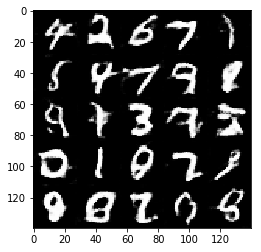

Epoch 1/2... Discriminator Loss: 0.9487... Generator Loss: 1.0667
Epoch 1/2... Discriminator Loss: 0.9246... Generator Loss: 1.6305
Epoch 1/2... Discriminator Loss: 0.8280... Generator Loss: 1.1156
Epoch 1/2... Discriminator Loss: 1.2560... Generator Loss: 0.7130
Epoch 1/2... Discriminator Loss: 1.4398... Generator Loss: 0.5748
Epoch 1/2... Discriminator Loss: 1.3384... Generator Loss: 2.0846
Epoch 1/2... Discriminator Loss: 1.2368... Generator Loss: 0.6749
Epoch 1/2... Discriminator Loss: 1.0973... Generator Loss: 0.7681
Epoch 1/2... Discriminator Loss: 1.6778... Generator Loss: 0.4395
Epoch 1/2... Discriminator Loss: 1.1961... Generator Loss: 0.6715


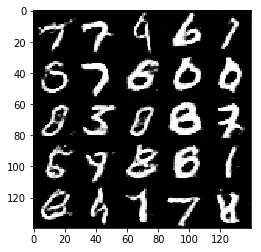

Epoch 1/2... Discriminator Loss: 0.6879... Generator Loss: 1.4127
Epoch 1/2... Discriminator Loss: 0.9820... Generator Loss: 1.2966
Epoch 1/2... Discriminator Loss: 1.4013... Generator Loss: 0.6220
Epoch 1/2... Discriminator Loss: 1.2708... Generator Loss: 0.6467
Epoch 1/2... Discriminator Loss: 0.9304... Generator Loss: 1.1317
Epoch 1/2... Discriminator Loss: 1.1235... Generator Loss: 0.8157
Epoch 1/2... Discriminator Loss: 0.7521... Generator Loss: 1.3860
Epoch 1/2... Discriminator Loss: 1.1117... Generator Loss: 0.8147
Epoch 1/2... Discriminator Loss: 1.8251... Generator Loss: 0.4222
Epoch 1/2... Discriminator Loss: 1.0361... Generator Loss: 0.9970


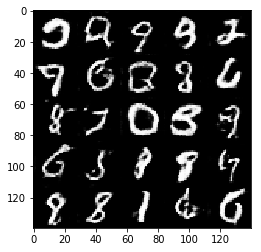

Epoch 1/2... Discriminator Loss: 0.8526... Generator Loss: 0.9928
Epoch 1/2... Discriminator Loss: 1.3089... Generator Loss: 2.2664
Epoch 1/2... Discriminator Loss: 0.7943... Generator Loss: 1.2620
Epoch 1/2... Discriminator Loss: 1.0337... Generator Loss: 1.6989
Epoch 1/2... Discriminator Loss: 0.9554... Generator Loss: 1.0072
Epoch 1/2... Discriminator Loss: 0.8940... Generator Loss: 1.0374
Epoch 1/2... Discriminator Loss: 1.7448... Generator Loss: 0.5102
Epoch 1/2... Discriminator Loss: 1.2293... Generator Loss: 0.7879
Epoch 1/2... Discriminator Loss: 1.4633... Generator Loss: 0.5301
Epoch 1/2... Discriminator Loss: 1.2037... Generator Loss: 0.6658


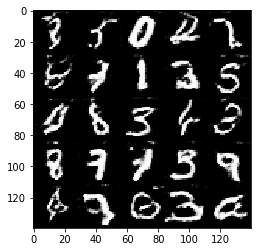

Epoch 1/2... Discriminator Loss: 1.2126... Generator Loss: 0.6720
Epoch 1/2... Discriminator Loss: 1.5755... Generator Loss: 0.4787
Epoch 1/2... Discriminator Loss: 1.0878... Generator Loss: 2.0894
Epoch 1/2... Discriminator Loss: 1.5720... Generator Loss: 0.5196
Epoch 1/2... Discriminator Loss: 1.0424... Generator Loss: 0.8192
Epoch 1/2... Discriminator Loss: 0.9383... Generator Loss: 1.0185
Epoch 1/2... Discriminator Loss: 0.8389... Generator Loss: 1.2677
Epoch 1/2... Discriminator Loss: 0.7890... Generator Loss: 1.5744
Epoch 1/2... Discriminator Loss: 0.7451... Generator Loss: 1.7945
Epoch 1/2... Discriminator Loss: 0.9277... Generator Loss: 1.2420


Epoch 1/2... Discriminator Loss: 0.9261... Generator Loss: 1.3367
Epoch 1/2... Discriminator Loss: 0.7732... Generator Loss: 1.6524
Epoch 1/2... Discriminator Loss: 1.9620... Generator Loss: 0.4035
Epoch 1/2... Discriminator Loss: 1.1374... Generator Loss: 1.4834
Epoch 1/2... Discriminator Loss: 0.9280... Generator Loss: 0.9530
Epoch 1/2... Discriminator Loss: 0.8960... Generator Loss: 0.9638
Epoch 1/2... Discriminator Loss: 1.0104... Generator Loss: 2.2369
Epoch 1/2... Discriminator Loss: 0.9189... Generator Loss: 0.9265
Epoch 1/2... Discriminator Loss: 1.1609... Generator Loss: 0.7897
Epoch 1/2... Discriminator Loss: 1.6272... Generator Loss: 0.5719


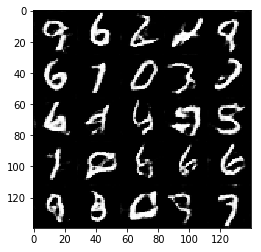

Epoch 1/2... Discriminator Loss: 1.2537... Generator Loss: 1.4574
Epoch 1/2... Discriminator Loss: 0.8035... Generator Loss: 1.5507
Epoch 1/2... Discriminator Loss: 0.7495... Generator Loss: 1.4035
Epoch 1/2... Discriminator Loss: 0.8173... Generator Loss: 1.3992
Epoch 1/2... Discriminator Loss: 0.9453... Generator Loss: 1.0609
Epoch 1/2... Discriminator Loss: 1.1523... Generator Loss: 0.6761
Epoch 1/2... Discriminator Loss: 1.1208... Generator Loss: 1.8094
Epoch 1/2... Discriminator Loss: 1.0089... Generator Loss: 0.8668
Epoch 1/2... Discriminator Loss: 1.0690... Generator Loss: 0.7730
Epoch 1/2... Discriminator Loss: 1.2171... Generator Loss: 0.6973


Epoch 1/2... Discriminator Loss: 1.3933... Generator Loss: 2.1422
Epoch 1/2... Discriminator Loss: 1.2510... Generator Loss: 2.1851
Epoch 1/2... Discriminator Loss: 1.0429... Generator Loss: 1.4842
Epoch 1/2... Discriminator Loss: 1.1880... Generator Loss: 0.7504
Epoch 1/2... Discriminator Loss: 0.8516... Generator Loss: 1.1972
Epoch 1/2... Discriminator Loss: 0.7573... Generator Loss: 1.2784
Epoch 1/2... Discriminator Loss: 0.7632... Generator Loss: 1.4082
Epoch 2/2... Discriminator Loss: 1.0514... Generator Loss: 1.0977
Epoch 2/2... Discriminator Loss: 0.9882... Generator Loss: 0.8250
Epoch 2/2... Discriminator Loss: 0.9531... Generator Loss: 0.8801


Epoch 2/2... Discriminator Loss: 0.7649... Generator Loss: 1.3410
Epoch 2/2... Discriminator Loss: 0.8821... Generator Loss: 1.0064
Epoch 2/2... Discriminator Loss: 1.3560... Generator Loss: 0.8141
Epoch 2/2... Discriminator Loss: 0.7878... Generator Loss: 1.3100
Epoch 2/2... Discriminator Loss: 1.4226... Generator Loss: 0.5562
Epoch 2/2... Discriminator Loss: 0.7877... Generator Loss: 1.2174
Epoch 2/2... Discriminator Loss: 0.9784... Generator Loss: 0.8854
Epoch 2/2... Discriminator Loss: 0.9521... Generator Loss: 0.9684
Epoch 2/2... Discriminator Loss: 1.2571... Generator Loss: 0.6891
Epoch 2/2... Discriminator Loss: 1.5852... Generator Loss: 0.5304


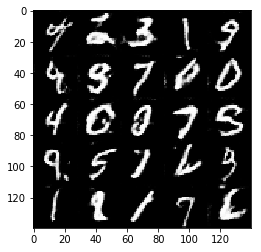

Epoch 2/2... Discriminator Loss: 0.8399... Generator Loss: 1.0397
Epoch 2/2... Discriminator Loss: 1.4001... Generator Loss: 3.0876
Epoch 2/2... Discriminator Loss: 0.6191... Generator Loss: 1.7677
Epoch 2/2... Discriminator Loss: 1.2451... Generator Loss: 2.3155
Epoch 2/2... Discriminator Loss: 0.9952... Generator Loss: 0.9163
Epoch 2/2... Discriminator Loss: 0.8511... Generator Loss: 1.5738
Epoch 2/2... Discriminator Loss: 1.1192... Generator Loss: 0.7135
Epoch 2/2... Discriminator Loss: 1.0439... Generator Loss: 0.8021
Epoch 2/2... Discriminator Loss: 0.9316... Generator Loss: 0.9902
Epoch 2/2... Discriminator Loss: 0.6269... Generator Loss: 2.1540


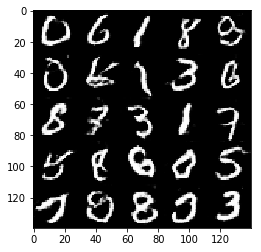

Epoch 2/2... Discriminator Loss: 0.7827... Generator Loss: 1.2704
Epoch 2/2... Discriminator Loss: 0.6663... Generator Loss: 1.8645
Epoch 2/2... Discriminator Loss: 1.5367... Generator Loss: 0.5974
Epoch 2/2... Discriminator Loss: 0.7331... Generator Loss: 1.4655
Epoch 2/2... Discriminator Loss: 1.1803... Generator Loss: 0.7642
Epoch 2/2... Discriminator Loss: 0.7717... Generator Loss: 1.2431
Epoch 2/2... Discriminator Loss: 0.9075... Generator Loss: 1.0155
Epoch 2/2... Discriminator Loss: 0.7559... Generator Loss: 1.5267
Epoch 2/2... Discriminator Loss: 0.9069... Generator Loss: 1.4133
Epoch 2/2... Discriminator Loss: 1.0265... Generator Loss: 0.9629


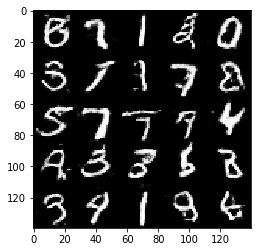

Epoch 2/2... Discriminator Loss: 0.7608... Generator Loss: 1.2886
Epoch 2/2... Discriminator Loss: 0.7197... Generator Loss: 1.3887
Epoch 2/2... Discriminator Loss: 0.7218... Generator Loss: 1.3184
Epoch 2/2... Discriminator Loss: 0.7503... Generator Loss: 1.2190
Epoch 2/2... Discriminator Loss: 0.6522... Generator Loss: 1.5124
Epoch 2/2... Discriminator Loss: 0.8305... Generator Loss: 1.1354
Epoch 2/2... Discriminator Loss: 0.7492... Generator Loss: 1.2353
Epoch 2/2... Discriminator Loss: 0.7832... Generator Loss: 1.2010
Epoch 2/2... Discriminator Loss: 1.2192... Generator Loss: 0.6930
Epoch 2/2... Discriminator Loss: 0.8668... Generator Loss: 0.9763


Epoch 2/2... Discriminator Loss: 1.2605... Generator Loss: 0.8343
Epoch 2/2... Discriminator Loss: 1.1517... Generator Loss: 2.2338
Epoch 2/2... Discriminator Loss: 0.6813... Generator Loss: 1.4014
Epoch 2/2... Discriminator Loss: 0.7603... Generator Loss: 1.2208
Epoch 2/2... Discriminator Loss: 0.8268... Generator Loss: 1.1710
Epoch 2/2... Discriminator Loss: 1.2812... Generator Loss: 0.7500
Epoch 2/2... Discriminator Loss: 0.7456... Generator Loss: 1.1598
Epoch 2/2... Discriminator Loss: 1.5777... Generator Loss: 2.6944
Epoch 2/2... Discriminator Loss: 1.1544... Generator Loss: 0.7939
Epoch 2/2... Discriminator Loss: 1.1897... Generator Loss: 0.7572


Epoch 2/2... Discriminator Loss: 0.7647... Generator Loss: 1.5117
Epoch 2/2... Discriminator Loss: 1.5574... Generator Loss: 0.5523
Epoch 2/2... Discriminator Loss: 0.6560... Generator Loss: 1.8842
Epoch 2/2... Discriminator Loss: 0.6585... Generator Loss: 1.5655
Epoch 2/2... Discriminator Loss: 0.6847... Generator Loss: 1.3779
Epoch 2/2... Discriminator Loss: 0.6096... Generator Loss: 1.5845
Epoch 2/2... Discriminator Loss: 1.4516... Generator Loss: 0.6340
Epoch 2/2... Discriminator Loss: 1.1810... Generator Loss: 0.6836
Epoch 2/2... Discriminator Loss: 1.9627... Generator Loss: 0.4350
Epoch 2/2... Discriminator Loss: 0.9564... Generator Loss: 0.9806


Epoch 2/2... Discriminator Loss: 0.8139... Generator Loss: 1.4354
Epoch 2/2... Discriminator Loss: 0.8271... Generator Loss: 1.8467
Epoch 2/2... Discriminator Loss: 1.1819... Generator Loss: 0.7549
Epoch 2/2... Discriminator Loss: 0.5485... Generator Loss: 2.1056
Epoch 2/2... Discriminator Loss: 0.5776... Generator Loss: 2.2179
Epoch 2/2... Discriminator Loss: 1.3866... Generator Loss: 0.5648
Epoch 2/2... Discriminator Loss: 0.7974... Generator Loss: 1.5629
Epoch 2/2... Discriminator Loss: 0.8793... Generator Loss: 1.2388
Epoch 2/2... Discriminator Loss: 0.7382... Generator Loss: 1.6975
Epoch 2/2... Discriminator Loss: 0.6642... Generator Loss: 1.5374


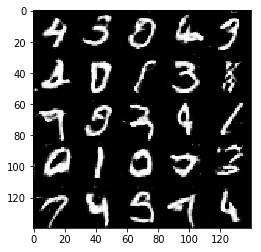

Epoch 2/2... Discriminator Loss: 1.3928... Generator Loss: 0.6922
Epoch 2/2... Discriminator Loss: 0.9462... Generator Loss: 0.9365
Epoch 2/2... Discriminator Loss: 1.2157... Generator Loss: 0.8663
Epoch 2/2... Discriminator Loss: 0.5984... Generator Loss: 1.6269
Epoch 2/2... Discriminator Loss: 0.9930... Generator Loss: 0.8890
Epoch 2/2... Discriminator Loss: 1.6605... Generator Loss: 0.5099
Epoch 2/2... Discriminator Loss: 0.6691... Generator Loss: 1.9138
Epoch 2/2... Discriminator Loss: 1.7876... Generator Loss: 0.4198
Epoch 2/2... Discriminator Loss: 1.1101... Generator Loss: 0.7472
Epoch 2/2... Discriminator Loss: 0.9389... Generator Loss: 1.5619


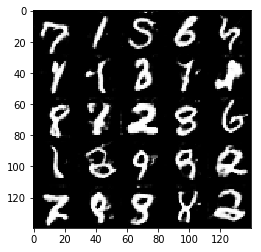

Epoch 2/2... Discriminator Loss: 0.6398... Generator Loss: 1.6857
Epoch 2/2... Discriminator Loss: 0.6498... Generator Loss: 1.5084
Epoch 2/2... Discriminator Loss: 0.8671... Generator Loss: 0.9899
Epoch 2/2... Discriminator Loss: 0.7049... Generator Loss: 1.2762
Epoch 2/2... Discriminator Loss: 0.7237... Generator Loss: 1.3739
Epoch 2/2... Discriminator Loss: 0.6293... Generator Loss: 1.6789
Epoch 2/2... Discriminator Loss: 0.7823... Generator Loss: 1.1963
Epoch 2/2... Discriminator Loss: 0.7240... Generator Loss: 1.4284
Epoch 2/2... Discriminator Loss: 0.9392... Generator Loss: 1.0018
Epoch 2/2... Discriminator Loss: 1.3657... Generator Loss: 0.6054


Epoch 2/2... Discriminator Loss: 0.9142... Generator Loss: 2.9141
Epoch 2/2... Discriminator Loss: 1.0139... Generator Loss: 0.9315
Epoch 2/2... Discriminator Loss: 0.6553... Generator Loss: 1.4488
Epoch 2/2... Discriminator Loss: 0.8730... Generator Loss: 0.9923
Epoch 2/2... Discriminator Loss: 0.7701... Generator Loss: 1.2087
Epoch 2/2... Discriminator Loss: 0.7106... Generator Loss: 1.8697
Epoch 2/2... Discriminator Loss: 0.6131... Generator Loss: 1.7206
Epoch 2/2... Discriminator Loss: 0.6021... Generator Loss: 1.5703
Epoch 2/2... Discriminator Loss: 0.5261... Generator Loss: 1.8358
Epoch 2/2... Discriminator Loss: 1.1931... Generator Loss: 0.7643


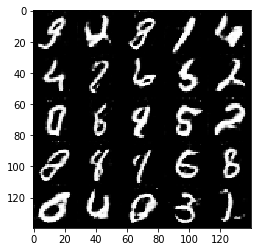

Epoch 2/2... Discriminator Loss: 0.5390... Generator Loss: 1.9422
Epoch 2/2... Discriminator Loss: 0.5199... Generator Loss: 1.8727
Epoch 2/2... Discriminator Loss: 0.8482... Generator Loss: 2.1285
Epoch 2/2... Discriminator Loss: 0.7677... Generator Loss: 1.2413
Epoch 2/2... Discriminator Loss: 0.9971... Generator Loss: 1.5875
Epoch 2/2... Discriminator Loss: 0.7523... Generator Loss: 1.1747
Epoch 2/2... Discriminator Loss: 0.8387... Generator Loss: 1.1487
Epoch 2/2... Discriminator Loss: 1.0628... Generator Loss: 0.9133
Epoch 2/2... Discriminator Loss: 0.5394... Generator Loss: 2.0358
Epoch 2/2... Discriminator Loss: 0.6462... Generator Loss: 1.4934


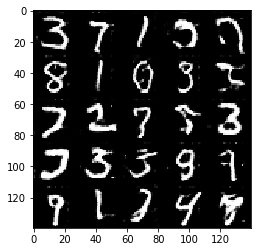

Epoch 2/2... Discriminator Loss: 0.9676... Generator Loss: 1.0020
Epoch 2/2... Discriminator Loss: 0.8288... Generator Loss: 1.2588
Epoch 2/2... Discriminator Loss: 1.0724... Generator Loss: 0.8239
Epoch 2/2... Discriminator Loss: 0.6952... Generator Loss: 1.8485
Epoch 2/2... Discriminator Loss: 0.8020... Generator Loss: 1.1062
Epoch 2/2... Discriminator Loss: 0.5456... Generator Loss: 1.8998
Epoch 2/2... Discriminator Loss: 0.7203... Generator Loss: 1.8283
Epoch 2/2... Discriminator Loss: 1.0992... Generator Loss: 0.8689
Epoch 2/2... Discriminator Loss: 0.9406... Generator Loss: 1.0770
Epoch 2/2... Discriminator Loss: 1.0644... Generator Loss: 0.9040


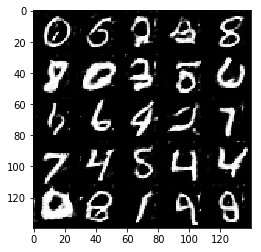

Epoch 2/2... Discriminator Loss: 0.7419... Generator Loss: 1.4809
Epoch 2/2... Discriminator Loss: 1.0366... Generator Loss: 0.8832
Epoch 2/2... Discriminator Loss: 2.3924... Generator Loss: 4.0820
Epoch 2/2... Discriminator Loss: 0.9017... Generator Loss: 0.9596
Epoch 2/2... Discriminator Loss: 1.1781... Generator Loss: 0.7310
Epoch 2/2... Discriminator Loss: 1.0072... Generator Loss: 2.0488
Epoch 2/2... Discriminator Loss: 0.8082... Generator Loss: 1.3722
Epoch 2/2... Discriminator Loss: 0.7594... Generator Loss: 1.2375
Epoch 2/2... Discriminator Loss: 0.7884... Generator Loss: 1.2542
Epoch 2/2... Discriminator Loss: 0.7775... Generator Loss: 1.1820


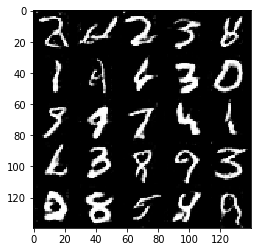

Epoch 2/2... Discriminator Loss: 1.2503... Generator Loss: 0.7916
Epoch 2/2... Discriminator Loss: 0.6966... Generator Loss: 1.3306
Epoch 2/2... Discriminator Loss: 1.1119... Generator Loss: 0.7967
Epoch 2/2... Discriminator Loss: 1.0390... Generator Loss: 0.8516
Epoch 2/2... Discriminator Loss: 0.8688... Generator Loss: 3.0032
Epoch 2/2... Discriminator Loss: 0.7265... Generator Loss: 1.4686
Epoch 2/2... Discriminator Loss: 0.6757... Generator Loss: 1.9795
Epoch 2/2... Discriminator Loss: 0.6023... Generator Loss: 1.5859
Epoch 2/2... Discriminator Loss: 0.6092... Generator Loss: 1.5926
Epoch 2/2... Discriminator Loss: 0.7858... Generator Loss: 1.6780


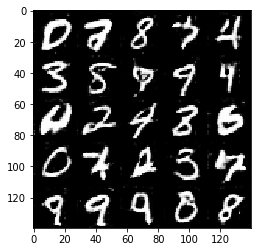

Epoch 2/2... Discriminator Loss: 0.5908... Generator Loss: 1.7582
Epoch 2/2... Discriminator Loss: 0.7715... Generator Loss: 1.1579
Epoch 2/2... Discriminator Loss: 1.6129... Generator Loss: 2.8016
Epoch 2/2... Discriminator Loss: 1.2191... Generator Loss: 0.8226
Epoch 2/2... Discriminator Loss: 0.8786... Generator Loss: 1.5144
Epoch 2/2... Discriminator Loss: 0.8286... Generator Loss: 1.6788
Epoch 2/2... Discriminator Loss: 0.8583... Generator Loss: 0.9674
Epoch 2/2... Discriminator Loss: 1.1669... Generator Loss: 0.7988
Epoch 2/2... Discriminator Loss: 0.8815... Generator Loss: 0.9657
Epoch 2/2... Discriminator Loss: 1.0816... Generator Loss: 0.8146


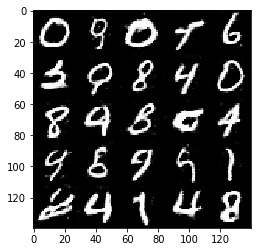

Epoch 2/2... Discriminator Loss: 1.1096... Generator Loss: 0.8259
Epoch 2/2... Discriminator Loss: 0.5151... Generator Loss: 2.2335
Epoch 2/2... Discriminator Loss: 1.1642... Generator Loss: 0.7722
Epoch 2/2... Discriminator Loss: 1.4724... Generator Loss: 0.5603
Epoch 2/2... Discriminator Loss: 0.5564... Generator Loss: 1.7723
Epoch 2/2... Discriminator Loss: 0.9839... Generator Loss: 0.9186
Epoch 2/2... Discriminator Loss: 2.2685... Generator Loss: 0.3803
Epoch 2/2... Discriminator Loss: 1.2162... Generator Loss: 0.8042
Epoch 2/2... Discriminator Loss: 1.0544... Generator Loss: 0.8356
Epoch 2/2... Discriminator Loss: 0.7497... Generator Loss: 1.2467


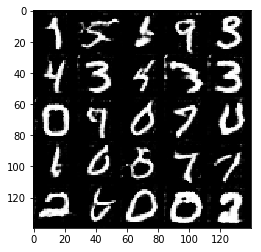

Epoch 2/2... Discriminator Loss: 1.7893... Generator Loss: 0.4725
Epoch 2/2... Discriminator Loss: 0.5557... Generator Loss: 1.7584
Epoch 2/2... Discriminator Loss: 0.8178... Generator Loss: 1.0679
Epoch 2/2... Discriminator Loss: 0.8555... Generator Loss: 1.1940
Epoch 2/2... Discriminator Loss: 1.3072... Generator Loss: 3.5327
Epoch 2/2... Discriminator Loss: 1.0663... Generator Loss: 2.2676
Epoch 2/2... Discriminator Loss: 0.6404... Generator Loss: 1.7042
Epoch 2/2... Discriminator Loss: 0.5306... Generator Loss: 1.9457
Epoch 2/2... Discriminator Loss: 1.1838... Generator Loss: 0.7877
Epoch 2/2... Discriminator Loss: 0.7923... Generator Loss: 1.3179


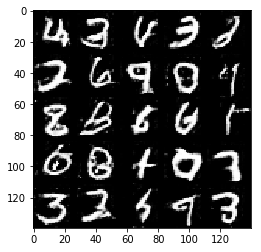

Epoch 2/2... Discriminator Loss: 0.9794... Generator Loss: 3.3521
Epoch 2/2... Discriminator Loss: 0.6242... Generator Loss: 1.5503
Epoch 2/2... Discriminator Loss: 0.6656... Generator Loss: 1.4261
Epoch 2/2... Discriminator Loss: 0.6545... Generator Loss: 1.5842
Epoch 2/2... Discriminator Loss: 0.4778... Generator Loss: 2.2227
Epoch 2/2... Discriminator Loss: 1.5524... Generator Loss: 2.6361
Epoch 2/2... Discriminator Loss: 0.8055... Generator Loss: 1.3876
Epoch 2/2... Discriminator Loss: 0.5578... Generator Loss: 1.7217
Epoch 2/2... Discriminator Loss: 0.7135... Generator Loss: 1.3954
Epoch 2/2... Discriminator Loss: 0.5678... Generator Loss: 1.6912


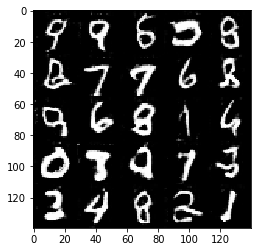

Epoch 2/2... Discriminator Loss: 0.8804... Generator Loss: 1.0644
Epoch 2/2... Discriminator Loss: 0.5994... Generator Loss: 1.5353
Epoch 2/2... Discriminator Loss: 1.6581... Generator Loss: 0.5253
Epoch 2/2... Discriminator Loss: 0.9293... Generator Loss: 0.9565
Epoch 2/2... Discriminator Loss: 0.6970... Generator Loss: 1.3305


In [35]:
# SUBMISSION 1:
# training nicely
# upped layer filter numbers by *2

# tried adding 4 hidden layers cascading down in length by half.  
# didn't put sigmoid.  training time substantially increased.
# result: images look like weird splotchy artifact not making numbers at all even after 600 steps

# added sigmoid, training seems to have gotten stuck on a noise pattern

# try only one added hidden layer with sigmoid.  
# discriminator converges now and generator generates 
# consistent pattern of noise that isn't learning

# removing sigmoid from hidden layer.  strangely discriminator loss starts at 0 and stays.
# hidden layer seems to be adding this waveform pattern that's causing problems.
# removing.

# keeping 128 256 512 filters
# seems to have artifact now where only top corners are white everything else black

# doubling learning_rate to 0.01

# trying dividing filter stack depths by 2 for 32 62 128 and batch 32
# that worked really well.  images looking pretty good now.
# decreasing learning_rate to 0.001

# SUBMISSION 2:
# updated alpha per suggestion from reviewer to 0.12 training to observe differences. seems to work similarly well as before. 
# curious as to why suggested.

# trying doubling the filter depths, per suggestion from reviewer. 64 128 256 numbers look good.
# trying adding smooth = 0.9 to model_loss d_loss_real per suggestion from reviewer.
# not clearly advantageous at this point

# trying learning rate between 0.0002 and 0.0008 and different values of Beta1 between 0.2 and 0.5
# lr 0.0005 beta1 0.35

# re-running after adding 0.9 and 0.1 smoothing to d_loss_fake and g_loss in model_loss

batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.35

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 4.2368... Generator Loss: 0.4599
Epoch 1/1... Discriminator Loss: 1.4832... Generator Loss: 1.3582
Epoch 1/1... Discriminator Loss: 1.9230... Generator Loss: 2.7324
Epoch 1/1... Discriminator Loss: 1.2855... Generator Loss: 2.2255
Epoch 1/1... Discriminator Loss: 1.2552... Generator Loss: 0.6266
Epoch 1/1... Discriminator Loss: 1.7195... Generator Loss: 0.4487
Epoch 1/1... Discriminator Loss: 1.6429... Generator Loss: 0.4758
Epoch 1/1... Discriminator Loss: 2.2050... Generator Loss: 0.4056
Epoch 1/1... Discriminator Loss: 1.2351... Generator Loss: 0.7141
Epoch 1/1... Discriminator Loss: 0.6405... Generator Loss: 3.4355


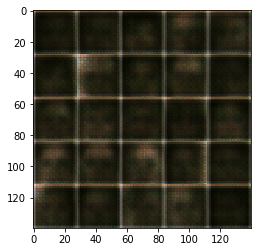

Epoch 1/1... Discriminator Loss: 1.9963... Generator Loss: 0.4076
Epoch 1/1... Discriminator Loss: 1.6764... Generator Loss: 3.0950
Epoch 1/1... Discriminator Loss: 0.6371... Generator Loss: 1.5722
Epoch 1/1... Discriminator Loss: 1.6478... Generator Loss: 0.5400
Epoch 1/1... Discriminator Loss: 1.3142... Generator Loss: 1.6069
Epoch 1/1... Discriminator Loss: 0.8424... Generator Loss: 1.1482
Epoch 1/1... Discriminator Loss: 0.7179... Generator Loss: 1.4407
Epoch 1/1... Discriminator Loss: 1.1339... Generator Loss: 0.9626
Epoch 1/1... Discriminator Loss: 1.6415... Generator Loss: 0.4560
Epoch 1/1... Discriminator Loss: 2.3361... Generator Loss: 0.3699


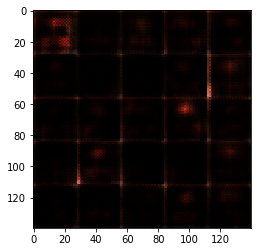

Epoch 1/1... Discriminator Loss: 1.2341... Generator Loss: 0.6436
Epoch 1/1... Discriminator Loss: 1.5950... Generator Loss: 0.4866
Epoch 1/1... Discriminator Loss: 1.1198... Generator Loss: 0.8997
Epoch 1/1... Discriminator Loss: 0.6779... Generator Loss: 1.3093
Epoch 1/1... Discriminator Loss: 1.1761... Generator Loss: 0.7702
Epoch 1/1... Discriminator Loss: 1.4566... Generator Loss: 0.5555
Epoch 1/1... Discriminator Loss: 1.1523... Generator Loss: 0.6561
Epoch 1/1... Discriminator Loss: 1.1337... Generator Loss: 0.7399
Epoch 1/1... Discriminator Loss: 0.5207... Generator Loss: 2.1954
Epoch 1/1... Discriminator Loss: 4.5464... Generator Loss: 3.6647


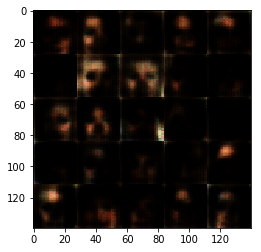

Epoch 1/1... Discriminator Loss: 1.1164... Generator Loss: 0.7210
Epoch 1/1... Discriminator Loss: 1.0531... Generator Loss: 2.8306
Epoch 1/1... Discriminator Loss: 1.8122... Generator Loss: 0.4149
Epoch 1/1... Discriminator Loss: 0.7901... Generator Loss: 1.3796
Epoch 1/1... Discriminator Loss: 1.7063... Generator Loss: 0.4731
Epoch 1/1... Discriminator Loss: 1.7165... Generator Loss: 0.4373
Epoch 1/1... Discriminator Loss: 0.7907... Generator Loss: 1.1062
Epoch 1/1... Discriminator Loss: 2.6006... Generator Loss: 0.3362
Epoch 1/1... Discriminator Loss: 1.2138... Generator Loss: 0.6432
Epoch 1/1... Discriminator Loss: 2.5422... Generator Loss: 0.3534


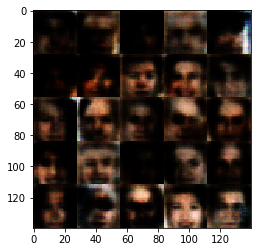

Epoch 1/1... Discriminator Loss: 0.9291... Generator Loss: 0.9115
Epoch 1/1... Discriminator Loss: 2.3636... Generator Loss: 2.9114
Epoch 1/1... Discriminator Loss: 1.0878... Generator Loss: 0.8308
Epoch 1/1... Discriminator Loss: 1.3281... Generator Loss: 0.5809
Epoch 1/1... Discriminator Loss: 1.1404... Generator Loss: 0.7594
Epoch 1/1... Discriminator Loss: 1.4945... Generator Loss: 0.4863
Epoch 1/1... Discriminator Loss: 0.8945... Generator Loss: 1.7591
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 2.8432
Epoch 1/1... Discriminator Loss: 1.0826... Generator Loss: 1.0155
Epoch 1/1... Discriminator Loss: 1.2885... Generator Loss: 0.6266


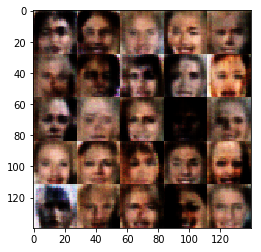

Epoch 1/1... Discriminator Loss: 1.3238... Generator Loss: 0.5585
Epoch 1/1... Discriminator Loss: 1.0453... Generator Loss: 0.7729
Epoch 1/1... Discriminator Loss: 1.0148... Generator Loss: 0.7962
Epoch 1/1... Discriminator Loss: 0.5524... Generator Loss: 1.6054
Epoch 1/1... Discriminator Loss: 1.0387... Generator Loss: 0.8355
Epoch 1/1... Discriminator Loss: 1.2621... Generator Loss: 1.0685
Epoch 1/1... Discriminator Loss: 0.7490... Generator Loss: 1.4298
Epoch 1/1... Discriminator Loss: 1.2416... Generator Loss: 0.8426
Epoch 1/1... Discriminator Loss: 1.0118... Generator Loss: 0.8258
Epoch 1/1... Discriminator Loss: 0.9062... Generator Loss: 1.0507


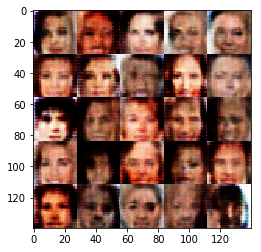

Epoch 1/1... Discriminator Loss: 1.5463... Generator Loss: 0.9905
Epoch 1/1... Discriminator Loss: 1.5022... Generator Loss: 1.2637
Epoch 1/1... Discriminator Loss: 0.8292... Generator Loss: 1.3468
Epoch 1/1... Discriminator Loss: 0.8166... Generator Loss: 0.9723
Epoch 1/1... Discriminator Loss: 1.2091... Generator Loss: 0.6656
Epoch 1/1... Discriminator Loss: 1.2805... Generator Loss: 0.5891
Epoch 1/1... Discriminator Loss: 1.3320... Generator Loss: 1.4209
Epoch 1/1... Discriminator Loss: 1.5000... Generator Loss: 0.4773
Epoch 1/1... Discriminator Loss: 1.1375... Generator Loss: 0.7972
Epoch 1/1... Discriminator Loss: 0.9555... Generator Loss: 0.8953


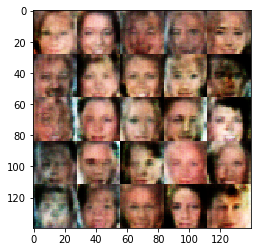

Epoch 1/1... Discriminator Loss: 1.1993... Generator Loss: 0.6230
Epoch 1/1... Discriminator Loss: 0.9710... Generator Loss: 0.7842
Epoch 1/1... Discriminator Loss: 1.6653... Generator Loss: 2.2054
Epoch 1/1... Discriminator Loss: 1.2294... Generator Loss: 0.6496
Epoch 1/1... Discriminator Loss: 1.2571... Generator Loss: 0.5898
Epoch 1/1... Discriminator Loss: 1.1880... Generator Loss: 0.9146
Epoch 1/1... Discriminator Loss: 0.7291... Generator Loss: 1.7878
Epoch 1/1... Discriminator Loss: 1.6765... Generator Loss: 0.5781
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.8975
Epoch 1/1... Discriminator Loss: 1.2867... Generator Loss: 0.7977


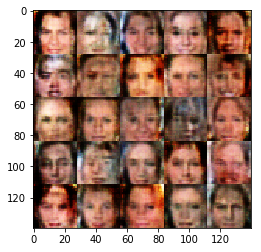

Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.8376
Epoch 1/1... Discriminator Loss: 1.3530... Generator Loss: 0.6314
Epoch 1/1... Discriminator Loss: 1.1262... Generator Loss: 0.6922
Epoch 1/1... Discriminator Loss: 1.3572... Generator Loss: 0.6453
Epoch 1/1... Discriminator Loss: 1.2480... Generator Loss: 0.6335
Epoch 1/1... Discriminator Loss: 0.7555... Generator Loss: 1.5213
Epoch 1/1... Discriminator Loss: 1.5477... Generator Loss: 0.5279
Epoch 1/1... Discriminator Loss: 1.0136... Generator Loss: 0.9573
Epoch 1/1... Discriminator Loss: 1.2710... Generator Loss: 0.9922
Epoch 1/1... Discriminator Loss: 1.2801... Generator Loss: 1.2567


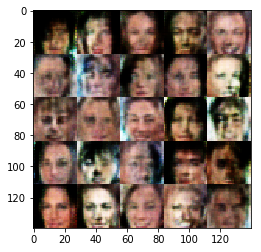

Epoch 1/1... Discriminator Loss: 1.3171... Generator Loss: 2.1002
Epoch 1/1... Discriminator Loss: 0.8985... Generator Loss: 1.0603
Epoch 1/1... Discriminator Loss: 0.9992... Generator Loss: 0.8877
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6101
Epoch 1/1... Discriminator Loss: 0.9514... Generator Loss: 1.0292
Epoch 1/1... Discriminator Loss: 1.8243... Generator Loss: 0.4266
Epoch 1/1... Discriminator Loss: 1.1286... Generator Loss: 1.0892
Epoch 1/1... Discriminator Loss: 1.1281... Generator Loss: 0.8624
Epoch 1/1... Discriminator Loss: 0.6939... Generator Loss: 1.3400
Epoch 1/1... Discriminator Loss: 0.9018... Generator Loss: 0.9401


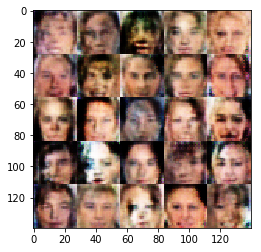

Epoch 1/1... Discriminator Loss: 1.5851... Generator Loss: 0.4585
Epoch 1/1... Discriminator Loss: 1.5586... Generator Loss: 1.2917
Epoch 1/1... Discriminator Loss: 1.0709... Generator Loss: 1.2587
Epoch 1/1... Discriminator Loss: 1.4522... Generator Loss: 0.5422
Epoch 1/1... Discriminator Loss: 0.9813... Generator Loss: 0.8268
Epoch 1/1... Discriminator Loss: 1.3387... Generator Loss: 1.0854
Epoch 1/1... Discriminator Loss: 1.2448... Generator Loss: 1.0671
Epoch 1/1... Discriminator Loss: 2.8575... Generator Loss: 2.3223
Epoch 1/1... Discriminator Loss: 1.1898... Generator Loss: 0.7831
Epoch 1/1... Discriminator Loss: 1.2513... Generator Loss: 0.6335


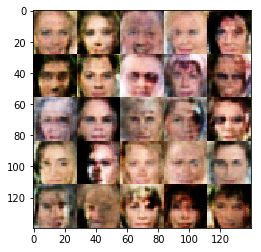

Epoch 1/1... Discriminator Loss: 1.2105... Generator Loss: 0.9872
Epoch 1/1... Discriminator Loss: 0.8606... Generator Loss: 0.9956
Epoch 1/1... Discriminator Loss: 2.0756... Generator Loss: 2.1014
Epoch 1/1... Discriminator Loss: 0.7092... Generator Loss: 1.3758
Epoch 1/1... Discriminator Loss: 1.2282... Generator Loss: 1.2702
Epoch 1/1... Discriminator Loss: 1.2948... Generator Loss: 0.7235
Epoch 1/1... Discriminator Loss: 2.0978... Generator Loss: 1.9256
Epoch 1/1... Discriminator Loss: 1.2297... Generator Loss: 1.0912
Epoch 1/1... Discriminator Loss: 0.8977... Generator Loss: 0.8924
Epoch 1/1... Discriminator Loss: 1.9573... Generator Loss: 0.3781


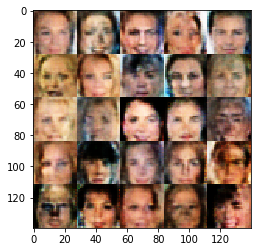

Epoch 1/1... Discriminator Loss: 1.2972... Generator Loss: 0.5914
Epoch 1/1... Discriminator Loss: 1.0632... Generator Loss: 0.9402
Epoch 1/1... Discriminator Loss: 1.0845... Generator Loss: 0.8144
Epoch 1/1... Discriminator Loss: 1.5677... Generator Loss: 1.3878
Epoch 1/1... Discriminator Loss: 1.2375... Generator Loss: 0.8177
Epoch 1/1... Discriminator Loss: 1.2178... Generator Loss: 1.5056
Epoch 1/1... Discriminator Loss: 1.5476... Generator Loss: 0.6210
Epoch 1/1... Discriminator Loss: 1.1642... Generator Loss: 0.7228
Epoch 1/1... Discriminator Loss: 1.8763... Generator Loss: 0.3940
Epoch 1/1... Discriminator Loss: 1.0983... Generator Loss: 0.9154


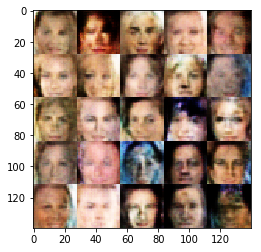

Epoch 1/1... Discriminator Loss: 1.0604... Generator Loss: 0.8831
Epoch 1/1... Discriminator Loss: 1.4339... Generator Loss: 0.7523
Epoch 1/1... Discriminator Loss: 0.7876... Generator Loss: 1.2090
Epoch 1/1... Discriminator Loss: 1.3242... Generator Loss: 0.8578
Epoch 1/1... Discriminator Loss: 1.0934... Generator Loss: 0.7499
Epoch 1/1... Discriminator Loss: 1.3312... Generator Loss: 0.8763
Epoch 1/1... Discriminator Loss: 1.3164... Generator Loss: 0.8467
Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 0.6687
Epoch 1/1... Discriminator Loss: 1.3378... Generator Loss: 0.7209
Epoch 1/1... Discriminator Loss: 1.4236... Generator Loss: 0.7272


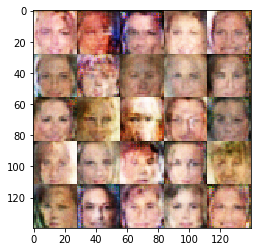

Epoch 1/1... Discriminator Loss: 1.3664... Generator Loss: 0.5425
Epoch 1/1... Discriminator Loss: 1.5460... Generator Loss: 0.4593
Epoch 1/1... Discriminator Loss: 1.8273... Generator Loss: 0.4105
Epoch 1/1... Discriminator Loss: 1.0804... Generator Loss: 1.1312
Epoch 1/1... Discriminator Loss: 1.9123... Generator Loss: 1.5439
Epoch 1/1... Discriminator Loss: 1.0140... Generator Loss: 0.8945
Epoch 1/1... Discriminator Loss: 1.3250... Generator Loss: 0.6272
Epoch 1/1... Discriminator Loss: 1.2827... Generator Loss: 0.9170
Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 0.5417
Epoch 1/1... Discriminator Loss: 1.2963... Generator Loss: 0.6492


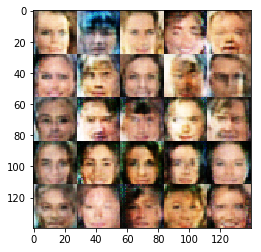

Epoch 1/1... Discriminator Loss: 1.1013... Generator Loss: 0.9708
Epoch 1/1... Discriminator Loss: 0.9666... Generator Loss: 0.8789
Epoch 1/1... Discriminator Loss: 1.4716... Generator Loss: 1.0679
Epoch 1/1... Discriminator Loss: 1.4505... Generator Loss: 1.2921
Epoch 1/1... Discriminator Loss: 1.3031... Generator Loss: 1.3665
Epoch 1/1... Discriminator Loss: 1.4409... Generator Loss: 0.5252
Epoch 1/1... Discriminator Loss: 1.0037... Generator Loss: 1.9952
Epoch 1/1... Discriminator Loss: 1.4390... Generator Loss: 0.5307
Epoch 1/1... Discriminator Loss: 1.4844... Generator Loss: 1.2393
Epoch 1/1... Discriminator Loss: 1.1995... Generator Loss: 0.6440


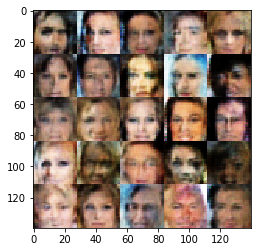

Epoch 1/1... Discriminator Loss: 1.2548... Generator Loss: 0.9939
Epoch 1/1... Discriminator Loss: 1.3025... Generator Loss: 0.7732
Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 0.7104
Epoch 1/1... Discriminator Loss: 1.4632... Generator Loss: 1.4578
Epoch 1/1... Discriminator Loss: 1.3369... Generator Loss: 0.7150
Epoch 1/1... Discriminator Loss: 1.3096... Generator Loss: 1.5188
Epoch 1/1... Discriminator Loss: 1.1385... Generator Loss: 1.4515
Epoch 1/1... Discriminator Loss: 1.1726... Generator Loss: 0.6897
Epoch 1/1... Discriminator Loss: 1.0053... Generator Loss: 1.1349
Epoch 1/1... Discriminator Loss: 1.1110... Generator Loss: 0.9708


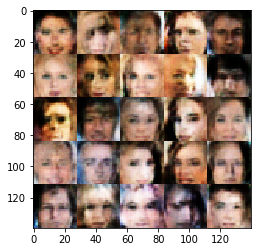

Epoch 1/1... Discriminator Loss: 1.4372... Generator Loss: 0.5282
Epoch 1/1... Discriminator Loss: 1.2212... Generator Loss: 0.6932
Epoch 1/1... Discriminator Loss: 1.3160... Generator Loss: 0.6945
Epoch 1/1... Discriminator Loss: 0.9464... Generator Loss: 0.9057
Epoch 1/1... Discriminator Loss: 1.3337... Generator Loss: 0.6241
Epoch 1/1... Discriminator Loss: 1.4908... Generator Loss: 0.5302
Epoch 1/1... Discriminator Loss: 1.2203... Generator Loss: 0.8282
Epoch 1/1... Discriminator Loss: 1.2360... Generator Loss: 0.6668
Epoch 1/1... Discriminator Loss: 1.2558... Generator Loss: 0.6075
Epoch 1/1... Discriminator Loss: 1.1700... Generator Loss: 0.7970


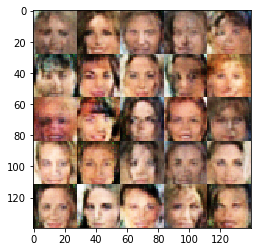

Epoch 1/1... Discriminator Loss: 1.1908... Generator Loss: 0.9178
Epoch 1/1... Discriminator Loss: 1.2707... Generator Loss: 0.8005
Epoch 1/1... Discriminator Loss: 1.3375... Generator Loss: 0.9564
Epoch 1/1... Discriminator Loss: 1.3549... Generator Loss: 1.1425
Epoch 1/1... Discriminator Loss: 1.4201... Generator Loss: 0.4986
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.5708
Epoch 1/1... Discriminator Loss: 1.1874... Generator Loss: 0.8073
Epoch 1/1... Discriminator Loss: 1.0225... Generator Loss: 0.9295
Epoch 1/1... Discriminator Loss: 1.5278... Generator Loss: 0.4995
Epoch 1/1... Discriminator Loss: 1.0035... Generator Loss: 0.7789


Epoch 1/1... Discriminator Loss: 1.3382... Generator Loss: 0.9069
Epoch 1/1... Discriminator Loss: 0.9409... Generator Loss: 1.0740
Epoch 1/1... Discriminator Loss: 1.5276... Generator Loss: 0.5260
Epoch 1/1... Discriminator Loss: 1.4916... Generator Loss: 0.4775
Epoch 1/1... Discriminator Loss: 1.2160... Generator Loss: 0.6233
Epoch 1/1... Discriminator Loss: 1.1590... Generator Loss: 0.6869
Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 1.6066
Epoch 1/1... Discriminator Loss: 1.4349... Generator Loss: 0.5181
Epoch 1/1... Discriminator Loss: 1.2032... Generator Loss: 0.7428
Epoch 1/1... Discriminator Loss: 1.6478... Generator Loss: 0.4519


Epoch 1/1... Discriminator Loss: 1.3036... Generator Loss: 0.6015
Epoch 1/1... Discriminator Loss: 0.9644... Generator Loss: 1.3351
Epoch 1/1... Discriminator Loss: 1.1170... Generator Loss: 0.6858
Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.5308
Epoch 1/1... Discriminator Loss: 0.9089... Generator Loss: 0.8546
Epoch 1/1... Discriminator Loss: 1.1988... Generator Loss: 0.6866
Epoch 1/1... Discriminator Loss: 1.2394... Generator Loss: 0.7178
Epoch 1/1... Discriminator Loss: 1.3721... Generator Loss: 0.6068
Epoch 1/1... Discriminator Loss: 1.4781... Generator Loss: 1.0667
Epoch 1/1... Discriminator Loss: 1.1932... Generator Loss: 0.6363


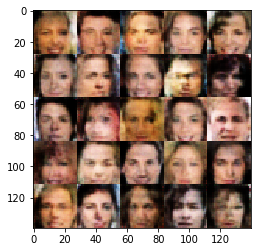

Epoch 1/1... Discriminator Loss: 1.2908... Generator Loss: 0.6301
Epoch 1/1... Discriminator Loss: 1.4482... Generator Loss: 0.5293
Epoch 1/1... Discriminator Loss: 0.9990... Generator Loss: 1.2837
Epoch 1/1... Discriminator Loss: 1.7216... Generator Loss: 0.4329
Epoch 1/1... Discriminator Loss: 1.1712... Generator Loss: 0.8644
Epoch 1/1... Discriminator Loss: 1.3440... Generator Loss: 0.5643
Epoch 1/1... Discriminator Loss: 1.3038... Generator Loss: 1.1563
Epoch 1/1... Discriminator Loss: 1.4746... Generator Loss: 0.4972
Epoch 1/1... Discriminator Loss: 1.1736... Generator Loss: 0.7943
Epoch 1/1... Discriminator Loss: 2.0678... Generator Loss: 0.3725


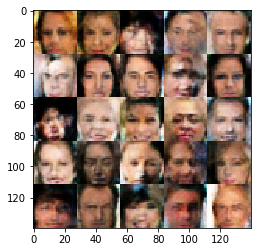

Epoch 1/1... Discriminator Loss: 1.0187... Generator Loss: 0.8847
Epoch 1/1... Discriminator Loss: 1.5537... Generator Loss: 0.4704
Epoch 1/1... Discriminator Loss: 1.5857... Generator Loss: 0.4444
Epoch 1/1... Discriminator Loss: 1.0117... Generator Loss: 0.8684
Epoch 1/1... Discriminator Loss: 1.9327... Generator Loss: 0.3923
Epoch 1/1... Discriminator Loss: 1.1592... Generator Loss: 0.7675
Epoch 1/1... Discriminator Loss: 0.6065... Generator Loss: 1.7004
Epoch 1/1... Discriminator Loss: 1.5157... Generator Loss: 0.4806
Epoch 1/1... Discriminator Loss: 1.4693... Generator Loss: 0.5039
Epoch 1/1... Discriminator Loss: 1.0593... Generator Loss: 0.7412


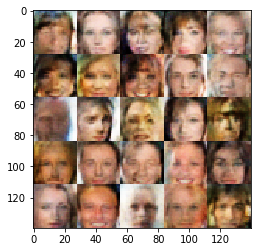

Epoch 1/1... Discriminator Loss: 1.6703... Generator Loss: 0.4528
Epoch 1/1... Discriminator Loss: 1.1948... Generator Loss: 1.3767
Epoch 1/1... Discriminator Loss: 1.0153... Generator Loss: 1.1374
Epoch 1/1... Discriminator Loss: 1.2617... Generator Loss: 0.9742
Epoch 1/1... Discriminator Loss: 1.1271... Generator Loss: 1.1831
Epoch 1/1... Discriminator Loss: 1.0205... Generator Loss: 1.2281
Epoch 1/1... Discriminator Loss: 1.5567... Generator Loss: 0.4699
Epoch 1/1... Discriminator Loss: 1.5072... Generator Loss: 0.5009
Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 0.5448
Epoch 1/1... Discriminator Loss: 1.1087... Generator Loss: 0.9290


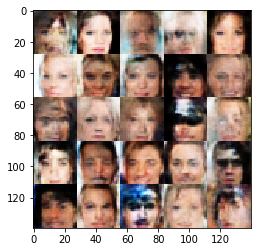

Epoch 1/1... Discriminator Loss: 1.2481... Generator Loss: 0.6502
Epoch 1/1... Discriminator Loss: 1.6593... Generator Loss: 0.4494
Epoch 1/1... Discriminator Loss: 1.6395... Generator Loss: 0.4354
Epoch 1/1... Discriminator Loss: 1.2352... Generator Loss: 0.6205
Epoch 1/1... Discriminator Loss: 1.2981... Generator Loss: 0.7260
Epoch 1/1... Discriminator Loss: 1.1573... Generator Loss: 0.8890
Epoch 1/1... Discriminator Loss: 1.0954... Generator Loss: 0.9645
Epoch 1/1... Discriminator Loss: 1.3018... Generator Loss: 1.0123
Epoch 1/1... Discriminator Loss: 1.0623... Generator Loss: 0.7748
Epoch 1/1... Discriminator Loss: 1.2177... Generator Loss: 1.1167


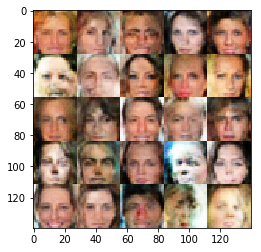

Epoch 1/1... Discriminator Loss: 1.8243... Generator Loss: 0.4021
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.9170
Epoch 1/1... Discriminator Loss: 1.0456... Generator Loss: 0.7452
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.5407
Epoch 1/1... Discriminator Loss: 1.2002... Generator Loss: 0.8087
Epoch 1/1... Discriminator Loss: 1.3460... Generator Loss: 0.6827
Epoch 1/1... Discriminator Loss: 1.5714... Generator Loss: 0.4825
Epoch 1/1... Discriminator Loss: 1.8240... Generator Loss: 0.3998
Epoch 1/1... Discriminator Loss: 1.6504... Generator Loss: 0.4389
Epoch 1/1... Discriminator Loss: 1.6067... Generator Loss: 0.5284


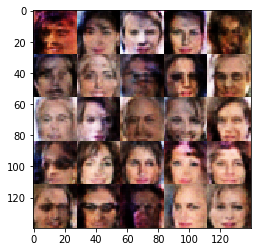

Epoch 1/1... Discriminator Loss: 1.4061... Generator Loss: 1.0885
Epoch 1/1... Discriminator Loss: 1.5862... Generator Loss: 0.4644
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6299
Epoch 1/1... Discriminator Loss: 1.2198... Generator Loss: 0.9257
Epoch 1/1... Discriminator Loss: 1.2838... Generator Loss: 0.8591
Epoch 1/1... Discriminator Loss: 1.2138... Generator Loss: 0.8062
Epoch 1/1... Discriminator Loss: 1.4903... Generator Loss: 0.4833
Epoch 1/1... Discriminator Loss: 1.1176... Generator Loss: 1.0340
Epoch 1/1... Discriminator Loss: 1.8016... Generator Loss: 0.4203
Epoch 1/1... Discriminator Loss: 1.7935... Generator Loss: 0.4131


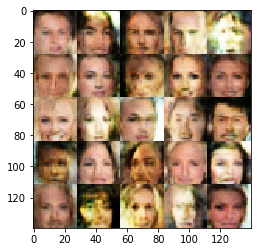

Epoch 1/1... Discriminator Loss: 1.2023... Generator Loss: 0.9624
Epoch 1/1... Discriminator Loss: 1.9001... Generator Loss: 0.3869
Epoch 1/1... Discriminator Loss: 1.0693... Generator Loss: 0.7495
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.5950
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.5322
Epoch 1/1... Discriminator Loss: 1.2421... Generator Loss: 0.6412
Epoch 1/1... Discriminator Loss: 1.5394... Generator Loss: 1.1913
Epoch 1/1... Discriminator Loss: 1.5280... Generator Loss: 0.8025
Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.9727
Epoch 1/1... Discriminator Loss: 1.6331... Generator Loss: 0.4481


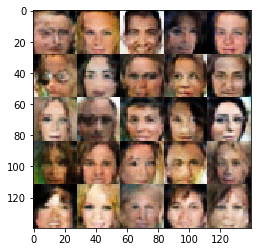

Epoch 1/1... Discriminator Loss: 1.4318... Generator Loss: 0.5117
Epoch 1/1... Discriminator Loss: 1.3378... Generator Loss: 0.6326
Epoch 1/1... Discriminator Loss: 1.1551... Generator Loss: 0.6907
Epoch 1/1... Discriminator Loss: 1.7257... Generator Loss: 0.4226
Epoch 1/1... Discriminator Loss: 1.1383... Generator Loss: 0.8224
Epoch 1/1... Discriminator Loss: 1.8137... Generator Loss: 0.4047
Epoch 1/1... Discriminator Loss: 1.4374... Generator Loss: 0.5122
Epoch 1/1... Discriminator Loss: 1.1658... Generator Loss: 0.9010
Epoch 1/1... Discriminator Loss: 1.1237... Generator Loss: 0.8126
Epoch 1/1... Discriminator Loss: 1.0590... Generator Loss: 1.1819


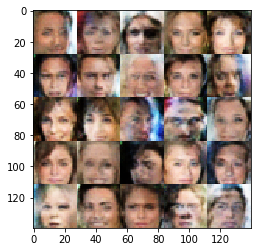

Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 0.6766
Epoch 1/1... Discriminator Loss: 1.3157... Generator Loss: 0.6148
Epoch 1/1... Discriminator Loss: 1.1193... Generator Loss: 1.0471
Epoch 1/1... Discriminator Loss: 1.1976... Generator Loss: 0.7585
Epoch 1/1... Discriminator Loss: 1.2388... Generator Loss: 0.8636
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.5754
Epoch 1/1... Discriminator Loss: 1.5271... Generator Loss: 0.7222
Epoch 1/1... Discriminator Loss: 1.3377... Generator Loss: 0.6161
Epoch 1/1... Discriminator Loss: 1.3360... Generator Loss: 0.8154
Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 0.9541


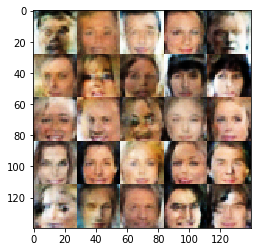

Epoch 1/1... Discriminator Loss: 1.4390... Generator Loss: 0.5161
Epoch 1/1... Discriminator Loss: 1.2946... Generator Loss: 0.7482
Epoch 1/1... Discriminator Loss: 1.5749... Generator Loss: 0.4894
Epoch 1/1... Discriminator Loss: 1.8997... Generator Loss: 0.4226
Epoch 1/1... Discriminator Loss: 1.4602... Generator Loss: 0.5145
Epoch 1/1... Discriminator Loss: 1.0322... Generator Loss: 0.9173
Epoch 1/1... Discriminator Loss: 1.5133... Generator Loss: 0.5239
Epoch 1/1... Discriminator Loss: 1.6014... Generator Loss: 0.4572
Epoch 1/1... Discriminator Loss: 1.4256... Generator Loss: 1.2267
Epoch 1/1... Discriminator Loss: 1.2564... Generator Loss: 0.6576


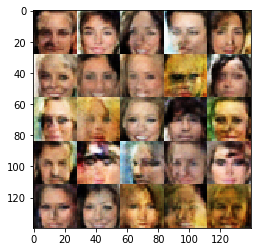

Epoch 1/1... Discriminator Loss: 1.6078... Generator Loss: 0.4800
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.5231
Epoch 1/1... Discriminator Loss: 1.2640... Generator Loss: 1.0436
Epoch 1/1... Discriminator Loss: 1.6308... Generator Loss: 0.4614
Epoch 1/1... Discriminator Loss: 1.4658... Generator Loss: 0.5059
Epoch 1/1... Discriminator Loss: 0.9426... Generator Loss: 1.0490
Epoch 1/1... Discriminator Loss: 1.0170... Generator Loss: 1.3682
Epoch 1/1... Discriminator Loss: 1.4942... Generator Loss: 0.5074
Epoch 1/1... Discriminator Loss: 1.6341... Generator Loss: 0.4382
Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 0.5615


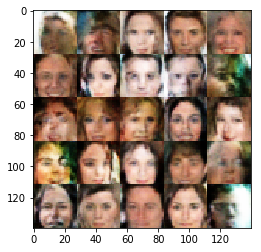

Epoch 1/1... Discriminator Loss: 1.9731... Generator Loss: 0.3909
Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.5446
Epoch 1/1... Discriminator Loss: 1.5132... Generator Loss: 0.5252
Epoch 1/1... Discriminator Loss: 1.2971... Generator Loss: 0.8523
Epoch 1/1... Discriminator Loss: 1.3344... Generator Loss: 1.2199
Epoch 1/1... Discriminator Loss: 1.7414... Generator Loss: 0.4114
Epoch 1/1... Discriminator Loss: 1.3029... Generator Loss: 0.5911
Epoch 1/1... Discriminator Loss: 1.3429... Generator Loss: 0.6159
Epoch 1/1... Discriminator Loss: 1.7132... Generator Loss: 0.4419
Epoch 1/1... Discriminator Loss: 1.0507... Generator Loss: 1.0301


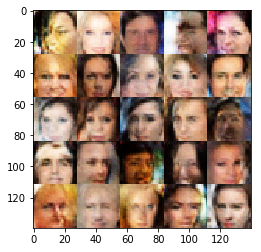

Epoch 1/1... Discriminator Loss: 1.2432... Generator Loss: 0.9430
Epoch 1/1... Discriminator Loss: 1.1488... Generator Loss: 0.7894
Epoch 1/1... Discriminator Loss: 1.5019... Generator Loss: 0.4871
Epoch 1/1... Discriminator Loss: 1.2388... Generator Loss: 0.6354
Epoch 1/1... Discriminator Loss: 1.2671... Generator Loss: 0.8518
Epoch 1/1... Discriminator Loss: 1.3090... Generator Loss: 0.6403
Epoch 1/1... Discriminator Loss: 1.2854... Generator Loss: 0.6015
Epoch 1/1... Discriminator Loss: 1.9445... Generator Loss: 0.4006
Epoch 1/1... Discriminator Loss: 1.2044... Generator Loss: 0.8573
Epoch 1/1... Discriminator Loss: 1.1887... Generator Loss: 0.8674


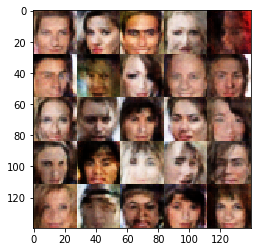

Epoch 1/1... Discriminator Loss: 1.2161... Generator Loss: 0.6826
Epoch 1/1... Discriminator Loss: 1.0043... Generator Loss: 0.9811
Epoch 1/1... Discriminator Loss: 1.0111... Generator Loss: 1.3593
Epoch 1/1... Discriminator Loss: 0.9590... Generator Loss: 0.9287
Epoch 1/1... Discriminator Loss: 1.1783... Generator Loss: 1.1379
Epoch 1/1... Discriminator Loss: 1.2238... Generator Loss: 0.7096
Epoch 1/1... Discriminator Loss: 1.6068... Generator Loss: 0.4440
Epoch 1/1... Discriminator Loss: 1.6484... Generator Loss: 0.4415
Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 0.5396
Epoch 1/1... Discriminator Loss: 1.1465... Generator Loss: 1.5132


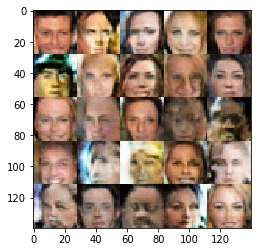

Epoch 1/1... Discriminator Loss: 1.2601... Generator Loss: 0.7146
Epoch 1/1... Discriminator Loss: 1.2407... Generator Loss: 0.6602
Epoch 1/1... Discriminator Loss: 1.2151... Generator Loss: 0.9884
Epoch 1/1... Discriminator Loss: 1.2775... Generator Loss: 0.6297
Epoch 1/1... Discriminator Loss: 1.3534... Generator Loss: 1.0170
Epoch 1/1... Discriminator Loss: 1.2456... Generator Loss: 0.6236
Epoch 1/1... Discriminator Loss: 1.4549... Generator Loss: 0.7635
Epoch 1/1... Discriminator Loss: 0.9668... Generator Loss: 0.9376
Epoch 1/1... Discriminator Loss: 1.3721... Generator Loss: 0.9696
Epoch 1/1... Discriminator Loss: 1.1766... Generator Loss: 0.7503


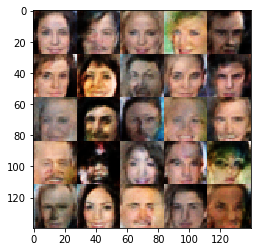

Epoch 1/1... Discriminator Loss: 1.2061... Generator Loss: 0.8869
Epoch 1/1... Discriminator Loss: 0.9039... Generator Loss: 1.0227
Epoch 1/1... Discriminator Loss: 1.4303... Generator Loss: 0.5413
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.5958
Epoch 1/1... Discriminator Loss: 1.2289... Generator Loss: 0.7985
Epoch 1/1... Discriminator Loss: 1.3264... Generator Loss: 0.7613
Epoch 1/1... Discriminator Loss: 1.5530... Generator Loss: 0.4822
Epoch 1/1... Discriminator Loss: 1.7048... Generator Loss: 0.4238
Epoch 1/1... Discriminator Loss: 1.5413... Generator Loss: 0.5132
Epoch 1/1... Discriminator Loss: 1.1624... Generator Loss: 0.7773


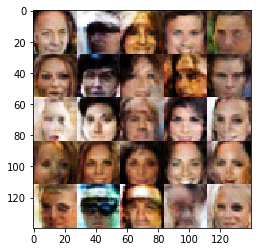

Epoch 1/1... Discriminator Loss: 1.1032... Generator Loss: 0.9307
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.7759
Epoch 1/1... Discriminator Loss: 1.4204... Generator Loss: 0.5821
Epoch 1/1... Discriminator Loss: 1.1754... Generator Loss: 0.7449
Epoch 1/1... Discriminator Loss: 1.6948... Generator Loss: 0.4423
Epoch 1/1... Discriminator Loss: 1.4889... Generator Loss: 0.5087
Epoch 1/1... Discriminator Loss: 1.7775... Generator Loss: 0.4076
Epoch 1/1... Discriminator Loss: 1.1945... Generator Loss: 0.8538
Epoch 1/1... Discriminator Loss: 1.1040... Generator Loss: 0.7120
Epoch 1/1... Discriminator Loss: 1.6063... Generator Loss: 0.4464


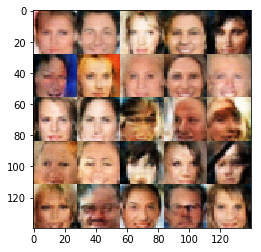

Epoch 1/1... Discriminator Loss: 1.2216... Generator Loss: 0.8853
Epoch 1/1... Discriminator Loss: 1.3372... Generator Loss: 0.6475
Epoch 1/1... Discriminator Loss: 1.3553... Generator Loss: 0.9057
Epoch 1/1... Discriminator Loss: 1.6581... Generator Loss: 0.4628
Epoch 1/1... Discriminator Loss: 1.2973... Generator Loss: 0.6039
Epoch 1/1... Discriminator Loss: 1.5466... Generator Loss: 0.4746
Epoch 1/1... Discriminator Loss: 1.4730... Generator Loss: 0.5264
Epoch 1/1... Discriminator Loss: 1.3088... Generator Loss: 0.7689
Epoch 1/1... Discriminator Loss: 1.2593... Generator Loss: 0.7406
Epoch 1/1... Discriminator Loss: 1.5673... Generator Loss: 0.4767


Epoch 1/1... Discriminator Loss: 1.1711... Generator Loss: 0.7542
Epoch 1/1... Discriminator Loss: 1.3163... Generator Loss: 0.6386
Epoch 1/1... Discriminator Loss: 1.5734... Generator Loss: 0.4653
Epoch 1/1... Discriminator Loss: 0.9188... Generator Loss: 0.9609
Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.8926
Epoch 1/1... Discriminator Loss: 1.2725... Generator Loss: 0.6422
Epoch 1/1... Discriminator Loss: 1.6584... Generator Loss: 0.4413
Epoch 1/1... Discriminator Loss: 1.1604... Generator Loss: 0.9328
Epoch 1/1... Discriminator Loss: 1.4540... Generator Loss: 0.5232
Epoch 1/1... Discriminator Loss: 1.2079... Generator Loss: 0.7208


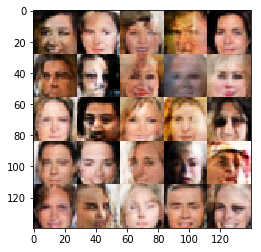

Epoch 1/1... Discriminator Loss: 1.4834... Generator Loss: 0.6474
Epoch 1/1... Discriminator Loss: 1.0115... Generator Loss: 1.0462
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.5941
Epoch 1/1... Discriminator Loss: 1.2610... Generator Loss: 0.7113
Epoch 1/1... Discriminator Loss: 1.7549... Generator Loss: 0.4135
Epoch 1/1... Discriminator Loss: 1.2965... Generator Loss: 0.6209
Epoch 1/1... Discriminator Loss: 1.3079... Generator Loss: 0.8048
Epoch 1/1... Discriminator Loss: 1.7245... Generator Loss: 0.4449
Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 0.9697
Epoch 1/1... Discriminator Loss: 1.6737... Generator Loss: 0.4303


Epoch 1/1... Discriminator Loss: 1.5778... Generator Loss: 0.4607
Epoch 1/1... Discriminator Loss: 1.1661... Generator Loss: 0.6655
Epoch 1/1... Discriminator Loss: 1.2440... Generator Loss: 0.8968
Epoch 1/1... Discriminator Loss: 1.2368... Generator Loss: 0.7277
Epoch 1/1... Discriminator Loss: 1.0658... Generator Loss: 0.9686
Epoch 1/1... Discriminator Loss: 1.1332... Generator Loss: 0.9772
Epoch 1/1... Discriminator Loss: 1.2595... Generator Loss: 0.8527
Epoch 1/1... Discriminator Loss: 1.3701... Generator Loss: 0.5963
Epoch 1/1... Discriminator Loss: 1.4814... Generator Loss: 0.5476
Epoch 1/1... Discriminator Loss: 1.7457... Generator Loss: 0.4120


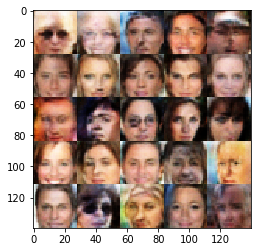

Epoch 1/1... Discriminator Loss: 1.9494... Generator Loss: 0.3720
Epoch 1/1... Discriminator Loss: 1.2034... Generator Loss: 0.7642
Epoch 1/1... Discriminator Loss: 1.4273... Generator Loss: 0.5477
Epoch 1/1... Discriminator Loss: 1.5942... Generator Loss: 0.4875
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.5463
Epoch 1/1... Discriminator Loss: 1.3427... Generator Loss: 0.8023
Epoch 1/1... Discriminator Loss: 1.1706... Generator Loss: 0.8641
Epoch 1/1... Discriminator Loss: 1.3013... Generator Loss: 0.7808
Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.5585
Epoch 1/1... Discriminator Loss: 1.1376... Generator Loss: 0.8813


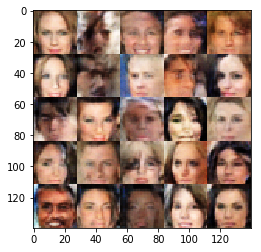

Epoch 1/1... Discriminator Loss: 1.1770... Generator Loss: 0.9651
Epoch 1/1... Discriminator Loss: 1.2571... Generator Loss: 0.6491
Epoch 1/1... Discriminator Loss: 1.0937... Generator Loss: 1.0185
Epoch 1/1... Discriminator Loss: 1.0932... Generator Loss: 0.7857
Epoch 1/1... Discriminator Loss: 1.5485... Generator Loss: 0.4951
Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 0.6906
Epoch 1/1... Discriminator Loss: 1.5469... Generator Loss: 0.4860
Epoch 1/1... Discriminator Loss: 1.6969... Generator Loss: 0.4385
Epoch 1/1... Discriminator Loss: 1.2282... Generator Loss: 0.9492
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.5609


Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.6041
Epoch 1/1... Discriminator Loss: 1.3721... Generator Loss: 0.6856
Epoch 1/1... Discriminator Loss: 1.5242... Generator Loss: 0.5219
Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.5213
Epoch 1/1... Discriminator Loss: 1.4528... Generator Loss: 0.5234
Epoch 1/1... Discriminator Loss: 1.5415... Generator Loss: 0.4844
Epoch 1/1... Discriminator Loss: 1.2971... Generator Loss: 0.6736
Epoch 1/1... Discriminator Loss: 1.7367... Generator Loss: 0.4233
Epoch 1/1... Discriminator Loss: 1.5087... Generator Loss: 0.4891
Epoch 1/1... Discriminator Loss: 1.3582... Generator Loss: 0.5478


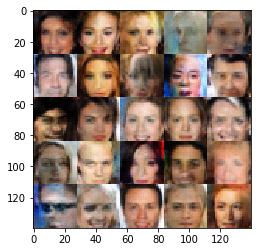

Epoch 1/1... Discriminator Loss: 1.1949... Generator Loss: 0.8554
Epoch 1/1... Discriminator Loss: 1.4881... Generator Loss: 0.4962
Epoch 1/1... Discriminator Loss: 1.5244... Generator Loss: 0.7333
Epoch 1/1... Discriminator Loss: 1.2813... Generator Loss: 0.9729
Epoch 1/1... Discriminator Loss: 2.0690... Generator Loss: 0.4120
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.5387
Epoch 1/1... Discriminator Loss: 1.4061... Generator Loss: 0.6635
Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.6266
Epoch 1/1... Discriminator Loss: 1.2472... Generator Loss: 0.6771
Epoch 1/1... Discriminator Loss: 1.0194... Generator Loss: 1.0759


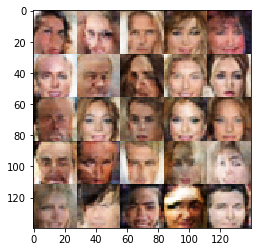

Epoch 1/1... Discriminator Loss: 1.4898... Generator Loss: 0.4889
Epoch 1/1... Discriminator Loss: 1.3276... Generator Loss: 0.7132
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.5484
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.6140
Epoch 1/1... Discriminator Loss: 1.2830... Generator Loss: 0.6259
Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.7459
Epoch 1/1... Discriminator Loss: 1.2692... Generator Loss: 0.8067
Epoch 1/1... Discriminator Loss: 1.2862... Generator Loss: 0.8645
Epoch 1/1... Discriminator Loss: 1.2779... Generator Loss: 0.6768
Epoch 1/1... Discriminator Loss: 1.4909... Generator Loss: 0.5082


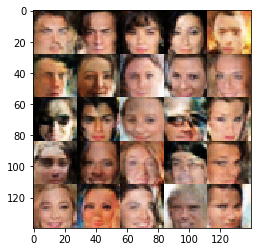

Epoch 1/1... Discriminator Loss: 1.3516... Generator Loss: 0.8411
Epoch 1/1... Discriminator Loss: 1.3188... Generator Loss: 0.7536
Epoch 1/1... Discriminator Loss: 1.6908... Generator Loss: 0.5231
Epoch 1/1... Discriminator Loss: 1.2362... Generator Loss: 0.6743
Epoch 1/1... Discriminator Loss: 1.4525... Generator Loss: 0.5247
Epoch 1/1... Discriminator Loss: 1.4089... Generator Loss: 0.5471
Epoch 1/1... Discriminator Loss: 1.3711... Generator Loss: 1.1065
Epoch 1/1... Discriminator Loss: 1.5669... Generator Loss: 0.5010
Epoch 1/1... Discriminator Loss: 1.3561... Generator Loss: 1.0640
Epoch 1/1... Discriminator Loss: 1.4372... Generator Loss: 0.5983


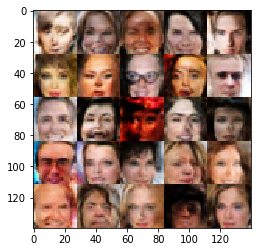

Epoch 1/1... Discriminator Loss: 1.4797... Generator Loss: 0.4837
Epoch 1/1... Discriminator Loss: 1.4622... Generator Loss: 0.5257
Epoch 1/1... Discriminator Loss: 1.1375... Generator Loss: 1.1458
Epoch 1/1... Discriminator Loss: 1.2332... Generator Loss: 1.1331
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.5637
Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.6702
Epoch 1/1... Discriminator Loss: 1.3102... Generator Loss: 0.7218
Epoch 1/1... Discriminator Loss: 1.1560... Generator Loss: 0.9545
Epoch 1/1... Discriminator Loss: 1.3055... Generator Loss: 0.9421
Epoch 1/1... Discriminator Loss: 1.2841... Generator Loss: 0.9866


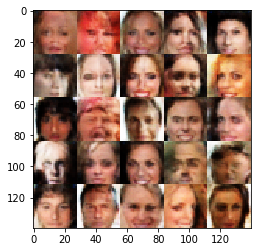

Epoch 1/1... Discriminator Loss: 1.2900... Generator Loss: 0.6350
Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.6623
Epoch 1/1... Discriminator Loss: 1.5286... Generator Loss: 0.4866
Epoch 1/1... Discriminator Loss: 1.2097... Generator Loss: 0.7632
Epoch 1/1... Discriminator Loss: 1.1988... Generator Loss: 1.1217
Epoch 1/1... Discriminator Loss: 1.1476... Generator Loss: 0.7031
Epoch 1/1... Discriminator Loss: 1.2047... Generator Loss: 0.7749
Epoch 1/1... Discriminator Loss: 1.2231... Generator Loss: 0.7187
Epoch 1/1... Discriminator Loss: 1.2919... Generator Loss: 0.9980
Epoch 1/1... Discriminator Loss: 1.3814... Generator Loss: 0.6036


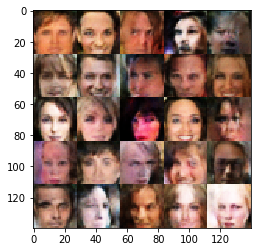

Epoch 1/1... Discriminator Loss: 1.2060... Generator Loss: 0.7954
Epoch 1/1... Discriminator Loss: 1.2320... Generator Loss: 0.7447
Epoch 1/1... Discriminator Loss: 1.3008... Generator Loss: 0.9924
Epoch 1/1... Discriminator Loss: 1.2272... Generator Loss: 0.6623
Epoch 1/1... Discriminator Loss: 1.5612... Generator Loss: 0.4631
Epoch 1/1... Discriminator Loss: 1.4567... Generator Loss: 0.5475
Epoch 1/1... Discriminator Loss: 1.2257... Generator Loss: 0.9222
Epoch 1/1... Discriminator Loss: 1.2880... Generator Loss: 0.7460
Epoch 1/1... Discriminator Loss: 1.1971... Generator Loss: 0.7348
Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.6873


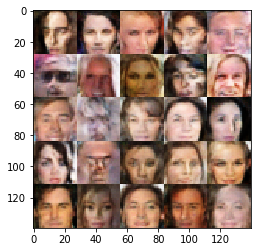

Epoch 1/1... Discriminator Loss: 1.3497... Generator Loss: 0.6164
Epoch 1/1... Discriminator Loss: 1.1473... Generator Loss: 0.9600
Epoch 1/1... Discriminator Loss: 1.1714... Generator Loss: 0.8202
Epoch 1/1... Discriminator Loss: 1.4867... Generator Loss: 0.5562
Epoch 1/1... Discriminator Loss: 1.2759... Generator Loss: 1.0515
Epoch 1/1... Discriminator Loss: 1.5071... Generator Loss: 0.5071
Epoch 1/1... Discriminator Loss: 1.5653... Generator Loss: 0.4952
Epoch 1/1... Discriminator Loss: 1.5619... Generator Loss: 0.4668
Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.5362
Epoch 1/1... Discriminator Loss: 1.2594... Generator Loss: 0.8919


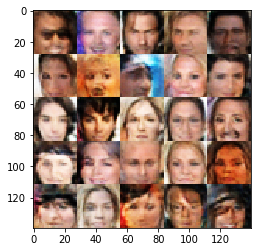

Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.5847
Epoch 1/1... Discriminator Loss: 1.5617... Generator Loss: 0.5176
Epoch 1/1... Discriminator Loss: 1.4697... Generator Loss: 0.5264
Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.6605
Epoch 1/1... Discriminator Loss: 1.3530... Generator Loss: 0.5777
Epoch 1/1... Discriminator Loss: 1.0957... Generator Loss: 0.8956
Epoch 1/1... Discriminator Loss: 1.7236... Generator Loss: 0.4252
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.5664
Epoch 1/1... Discriminator Loss: 1.2510... Generator Loss: 0.6932
Epoch 1/1... Discriminator Loss: 1.2840... Generator Loss: 0.6986


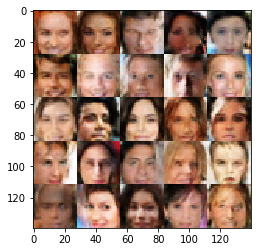

Epoch 1/1... Discriminator Loss: 1.3618... Generator Loss: 1.0221
Epoch 1/1... Discriminator Loss: 1.5321... Generator Loss: 0.4759
Epoch 1/1... Discriminator Loss: 1.5269... Generator Loss: 0.4732
Epoch 1/1... Discriminator Loss: 1.4872... Generator Loss: 0.5065
Epoch 1/1... Discriminator Loss: 1.3027... Generator Loss: 0.7373
Epoch 1/1... Discriminator Loss: 1.2313... Generator Loss: 0.8167
Epoch 1/1... Discriminator Loss: 1.1758... Generator Loss: 0.6944
Epoch 1/1... Discriminator Loss: 1.5286... Generator Loss: 0.5118
Epoch 1/1... Discriminator Loss: 1.4373... Generator Loss: 0.6470
Epoch 1/1... Discriminator Loss: 1.0421... Generator Loss: 1.2378


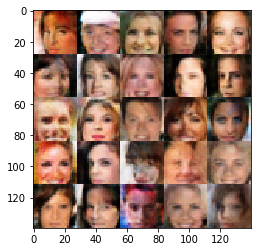

Epoch 1/1... Discriminator Loss: 1.4826... Generator Loss: 0.5261
Epoch 1/1... Discriminator Loss: 1.2093... Generator Loss: 0.7238
Epoch 1/1... Discriminator Loss: 1.6500... Generator Loss: 0.4623
Epoch 1/1... Discriminator Loss: 1.3216... Generator Loss: 0.5960
Epoch 1/1... Discriminator Loss: 1.3570... Generator Loss: 0.5426
Epoch 1/1... Discriminator Loss: 1.2216... Generator Loss: 0.9013
Epoch 1/1... Discriminator Loss: 1.2365... Generator Loss: 0.8677
Epoch 1/1... Discriminator Loss: 1.3153... Generator Loss: 0.7214
Epoch 1/1... Discriminator Loss: 1.3493... Generator Loss: 0.7057
Epoch 1/1... Discriminator Loss: 1.5099... Generator Loss: 0.5184


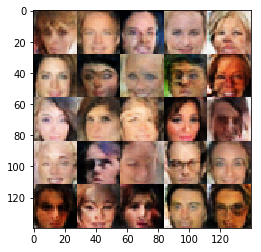

Epoch 1/1... Discriminator Loss: 1.1339... Generator Loss: 0.8338
Epoch 1/1... Discriminator Loss: 1.3454... Generator Loss: 0.7097
Epoch 1/1... Discriminator Loss: 1.4613... Generator Loss: 0.5301
Epoch 1/1... Discriminator Loss: 1.1883... Generator Loss: 1.0637
Epoch 1/1... Discriminator Loss: 1.3301... Generator Loss: 0.7936
Epoch 1/1... Discriminator Loss: 1.4614... Generator Loss: 0.5990
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.9618
Epoch 1/1... Discriminator Loss: 1.2201... Generator Loss: 0.7419
Epoch 1/1... Discriminator Loss: 1.1956... Generator Loss: 0.7521
Epoch 1/1... Discriminator Loss: 1.3600... Generator Loss: 0.5781


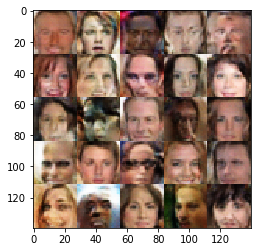

Epoch 1/1... Discriminator Loss: 1.2885... Generator Loss: 0.5997
Epoch 1/1... Discriminator Loss: 1.0723... Generator Loss: 1.0180
Epoch 1/1... Discriminator Loss: 1.2860... Generator Loss: 0.6494
Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 1.0079
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.5827
Epoch 1/1... Discriminator Loss: 1.2064... Generator Loss: 0.7391
Epoch 1/1... Discriminator Loss: 1.4491... Generator Loss: 0.5258
Epoch 1/1... Discriminator Loss: 1.1062... Generator Loss: 0.8363
Epoch 1/1... Discriminator Loss: 1.9089... Generator Loss: 0.3930
Epoch 1/1... Discriminator Loss: 1.2392... Generator Loss: 1.0573


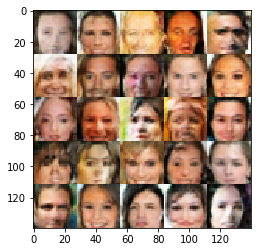

Epoch 1/1... Discriminator Loss: 1.5023... Generator Loss: 0.5005
Epoch 1/1... Discriminator Loss: 1.4695... Generator Loss: 0.5074
Epoch 1/1... Discriminator Loss: 1.2664... Generator Loss: 0.6658
Epoch 1/1... Discriminator Loss: 1.2957... Generator Loss: 0.5829
Epoch 1/1... Discriminator Loss: 1.5366... Generator Loss: 0.4872
Epoch 1/1... Discriminator Loss: 1.2554... Generator Loss: 0.7841
Epoch 1/1... Discriminator Loss: 1.2969... Generator Loss: 0.6155
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.5747
Epoch 1/1... Discriminator Loss: 1.4531... Generator Loss: 0.5242
Epoch 1/1... Discriminator Loss: 1.7124... Generator Loss: 0.4210


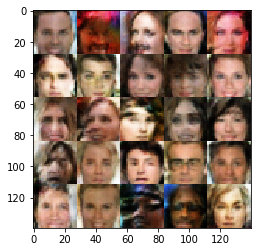

Epoch 1/1... Discriminator Loss: 1.4563... Generator Loss: 0.7616
Epoch 1/1... Discriminator Loss: 1.2042... Generator Loss: 0.7824
Epoch 1/1... Discriminator Loss: 1.3240... Generator Loss: 0.5780
Epoch 1/1... Discriminator Loss: 1.6774... Generator Loss: 0.4571
Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 0.6416
Epoch 1/1... Discriminator Loss: 1.4937... Generator Loss: 0.5047
Epoch 1/1... Discriminator Loss: 1.3248... Generator Loss: 0.6475
Epoch 1/1... Discriminator Loss: 1.1811... Generator Loss: 0.8900
Epoch 1/1... Discriminator Loss: 1.4704... Generator Loss: 0.5157
Epoch 1/1... Discriminator Loss: 1.4719... Generator Loss: 0.5235


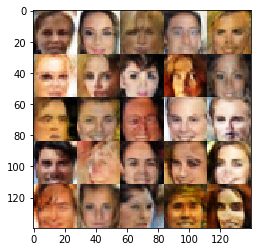

Epoch 1/1... Discriminator Loss: 1.2918... Generator Loss: 0.6140
Epoch 1/1... Discriminator Loss: 1.5684... Generator Loss: 0.4740
Epoch 1/1... Discriminator Loss: 1.3626... Generator Loss: 0.7934
Epoch 1/1... Discriminator Loss: 1.4293... Generator Loss: 0.5458
Epoch 1/1... Discriminator Loss: 1.2142... Generator Loss: 0.8774
Epoch 1/1... Discriminator Loss: 1.4759... Generator Loss: 0.5066
Epoch 1/1... Discriminator Loss: 1.2318... Generator Loss: 0.6795
Epoch 1/1... Discriminator Loss: 1.2500... Generator Loss: 0.6659
Epoch 1/1... Discriminator Loss: 1.3760... Generator Loss: 0.5740
Epoch 1/1... Discriminator Loss: 1.2938... Generator Loss: 0.6044


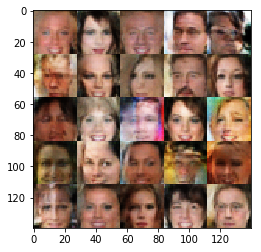

Epoch 1/1... Discriminator Loss: 1.3535... Generator Loss: 0.5855
Epoch 1/1... Discriminator Loss: 1.1930... Generator Loss: 0.7349
Epoch 1/1... Discriminator Loss: 1.4410... Generator Loss: 0.5074
Epoch 1/1... Discriminator Loss: 1.5633... Generator Loss: 0.4774
Epoch 1/1... Discriminator Loss: 1.4552... Generator Loss: 0.5111
Epoch 1/1... Discriminator Loss: 1.2963... Generator Loss: 0.6336
Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.6957
Epoch 1/1... Discriminator Loss: 1.3038... Generator Loss: 0.5982
Epoch 1/1... Discriminator Loss: 1.6132... Generator Loss: 0.4660
Epoch 1/1... Discriminator Loss: 1.4529... Generator Loss: 0.7524


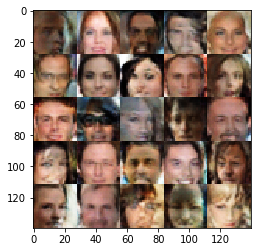

Epoch 1/1... Discriminator Loss: 1.4453... Generator Loss: 0.5245
Epoch 1/1... Discriminator Loss: 1.5744... Generator Loss: 0.4688
Epoch 1/1... Discriminator Loss: 1.2426... Generator Loss: 0.6912
Epoch 1/1... Discriminator Loss: 1.3153... Generator Loss: 0.6261
Epoch 1/1... Discriminator Loss: 1.3774... Generator Loss: 1.3524
Epoch 1/1... Discriminator Loss: 1.6480... Generator Loss: 0.4524
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.5244
Epoch 1/1... Discriminator Loss: 1.1515... Generator Loss: 0.8132
Epoch 1/1... Discriminator Loss: 1.3181... Generator Loss: 0.9021
Epoch 1/1... Discriminator Loss: 1.5689... Generator Loss: 0.4753


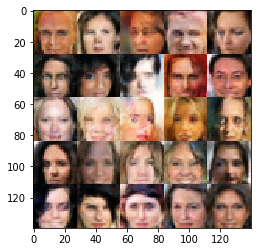

Epoch 1/1... Discriminator Loss: 1.0505... Generator Loss: 0.8083
Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.7862
Epoch 1/1... Discriminator Loss: 1.3028... Generator Loss: 0.7149
Epoch 1/1... Discriminator Loss: 1.1489... Generator Loss: 0.9290
Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.6159
Epoch 1/1... Discriminator Loss: 1.2168... Generator Loss: 0.8541
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.9390
Epoch 1/1... Discriminator Loss: 1.3690... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 1.1920... Generator Loss: 0.7199
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.5771


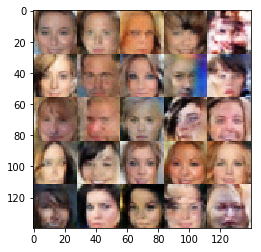

Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.5532
Epoch 1/1... Discriminator Loss: 1.1768... Generator Loss: 1.2558
Epoch 1/1... Discriminator Loss: 1.6805... Generator Loss: 0.4409


In [34]:
# not clearly seeing improvement from reviewer suggestions at this point.
# trying adding 0.9 and 0.1 smoothing to d_loss_fake and g_loss in model_loss
# learning rate 0.0004
# Looking pretty good!  submitting.

batch_size = 32
z_dim = 100
learning_rate = 0.0004
beta1 = 0.2

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.